# Utilis 
## Run for all tasks！

In [1]:
import sys
import os
import pandas as pd
sys.path.append('../..')
from Core.Utils.utils import *


c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set working location: Cluster or Local

**Large data over 100MB**: data_path 


**smaller data under 10MB**: local git path


In [2]:
import glob
from abc import ABC, abstractmethod
import os
import umap
import numpy as np
import pandas as pd
import pandas as pd
from functools import partial
# Define the partial function with a fixed folder and embedding_folder
def search_csv_file(environment_path,search_folder,file_name):
    # Create a partial function to capture the pattern matching
    pattern = os.path.join(environment_path, search_folder, '**', file_name)
    return glob.glob(pattern, recursive=True)[0]  # Get the first match

# Example usage
folder = 'your_main_folder'
def random_sample(df, percentage=0.1):
    """
    Randomly sample a percentage of rows from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to sample from.
    percentage (float): The percentage of rows to sample (default is 0.1).
    
    Returns:
    pd.DataFrame: A DataFrame containing the sampled rows.
    """
    return df.sample(frac=percentage)
class PathStrategy(ABC):
    """
    Strategy interface for getting data paths.
    """
    def __init__(self, environment_path: str) -> None:
        self.environment_path = environment_path

    @abstractmethod
    def get_data_path(self):
        pass

    def find_file_from_data_path(self, filename: str):
        """
        Utility method to find a file with a specific name within the data directory.
        """
        search_path = os.path.join(self.get_data_path(), '**', filename)
        matching_files = glob.glob(search_path, recursive=True)
        if matching_files:
            return matching_files[0]  # Return the first match found
        else:
            raise FileNotFoundError(f"{filename} not found in {self.get_data_path()}")


class LocalPathStrategy(PathStrategy):
    def get_data_path(self):
        # Implementation specific to local paths
        return f"{self.environment_path}/Data"


class ClusterPathStrategy(PathStrategy):
    def get_data_path(self):
        # Implementation specific to cluster paths
        return f"{self.environment_path}/Data"


class WorkPath:
    def __init__(self, location: str) -> None:
        self.location = location
        self.environment_path = self._get_environment_path()
        self.path_strategy = self._create_path_strategy()

    @property
    def data_path(self):
        return self.path_strategy.get_data_path()

    def find_file_from_data_path(self, filename: str):
        print('This is find path',self.path_strategy.find_file_from_data_path(filename))
        return self.path_strategy.find_file_from_data_path(filename)

    def _get_environment_path(self):
        """
        Get the environment path based on the location.
        """
        if self.location == 'cluster':
            return '/mnt/yizhou/'
        elif self.location == 'local':
            return 'C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习'
    
    def _create_path_strategy(self):
        """
        Create the appropriate path strategy based on the location.
        """
        if self.location == 'cluster':
            return ClusterPathStrategy(self.environment_path)
        elif self.location == 'local':
            return LocalPathStrategy(self.environment_path)





In [3]:

class ESMEmbedding:
    def __init__(self, work_path: WorkPath):
        self.work_path = work_path

    @property
    def esm2_embedding(self):
        return load_esm_embedding(self.work_path.find_file_from_data_path('total_esm2_embedding.pkl'))

    @property
    def esm3_embedding(self):
        return load_esm_embedding(self.work_path.find_file_from_data_path('total_esm3_normalized_embedding.pkl'))


def get_umap_embeddings(esm_embedding, umap_config):
    # Configure UMAP parameters for Euclidean distance

    # Compute UMAP embedding using Euclidean distance
    umap_reducer = umap.UMAP(**umap_config)
    umap_embedding = umap_reducer.fit_transform(esm_embedding)

    return umap_embedding

import seaborn as sns
def creat_cosomo_embedding(umap_embedding,signature_label):
    umap_df = pd.DataFrame(umap_embedding,columns=['x','y'])
    umap_df['type'] = signature_label
    umap_df['id'] = umap_df.index

    #get color for each id
    labels = umap_df['type'] #type is label
    unique_labels = np.unique(labels)
    # 生成基础调色板
    base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))
    # 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
    # 确保为所有标签分配颜色，包括缺失的
    palette = {label: (base_palette[i]) for i, label in enumerate(unique_labels)}
    umap_df['color'] = umap_df['type'].map(palette)
    return umap_df

def save_cosmo_embedding(umap_df,out_name):
    umap_df.to_csv(f'/mnt/yizhou/Shenzhen_GLM_Project/Output/ESM/ESM_Embedding_Cosmograph/{out_name}.csv')

import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

def plot_scatter_with_labels(euc_df, cos_df):
    """
    Plot scatter plots with labels from two DataFrames: one for Euclidean distance and one for Cosine similarity.

    Parameters:
    euc_df (pd.DataFrame): DataFrame containing columns 'x', 'y', 'type', and 'color' for Euclidean distance.
    cos_df (pd.DataFrame): DataFrame containing columns 'x', 'y', 'type', and 'color' for Cosine similarity.
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))

    # Plot Euclidean distance scatter plot
    unique_labels = euc_df['type'].unique()
    for label in unique_labels:
        subset = euc_df[euc_df['type'] == label]
        axes[0].scatter(subset['x'], subset['y'], color=subset['color'].iloc[0], label=label, s=10)
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].set_title('UMAP Embedding with Euclidean Distance')
    axes[0].legend()

    # Plot Cosine similarity scatter plot
    unique_labels = cos_df['type'].unique()
    for label in unique_labels:
        subset = cos_df[cos_df['type'] == label]
        axes[1].scatter(subset['x'], subset['y'], color=subset['color'].iloc[0], label=label, s=10)
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].set_title('UMAP Embedding with Cosine Similarity')
    axes[1].legend()

    plt.show()
# Example of setting up the environment
LOCATION = 'local'
work_path = WorkPath(LOCATION)


In [99]:
total_interpro_df = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')

In [ ]:

#add columns to raw data
# new_column_names = [
#     'Protein accession',
#     'Sequence MD5 digest',
#     'Sequence length',
#     'Analysis',
#     'Signature accession',
#     'Signature description',
#     'Start location',
#     'Stop location',
#     'Score',
#     'Status',
#     'Date',
#     'InterPro annotations - accession',
#     'InterPro annotations - description',
#     'GO annotations',
#     'Pathways annotations'
# ]
#total_interpro_df.columns = new_column_names # add columns to raw data

#total_interpro_df.to_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t',index=False,header=True) # save to file

# ESM-2 Embedding with UMAP

## Extract embedding 

In [264]:
esm_embedding, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding

## Find top 10 pfam from Interpro scan

In [265]:
import pandas as pd
interpro_result = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')
#sort by protein accession
interpro_result = interpro_result.sort_values(by='Protein accession')

In [268]:
import numpy as np
def get_top_pfam_labels(interpro_result,top=10):
    """
    args:
        interpro_result: interpro result dataframe
        top: top n most frequent labels of pfam
    """

    #filter labels from pfam database
    pfam_labels = interpro_result[interpro_result['Analysis']=='Pfam']
    # top 10 most frequent labels
    top_labels = pfam_labels['Signature description'].value_counts().index[:top]
    # filter data with top 10 labels
    top_labels_data = pfam_labels[pfam_labels['Signature description'].isin(top_labels)].reset_index(drop=True)

    return top_labels_data 

def get_non_duplicated_top_pfam_labels(top_pfam_labels):
    #remove duplicated protein accessions
    top_pfam_labels = top_pfam_labels.drop_duplicates(subset=['Protein accession'])
    return top_pfam_labels


def get_non_duplicated_pfam_labels(interpro_result):
    # Keep rows where the Analysis column is 'Pfam'
    pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam']
    
    # Find protein accessions that do not have Pfam annotations
    non_pfam_proteins = interpro_result[~interpro_result['Protein accession'].isin(pfam_labels['Protein accession'])]
    
    # From non_pfam_proteins, keep the first occurrence of each protein accession
    non_pfam_unique = non_pfam_proteins.drop_duplicates(subset=['Protein accession'], keep='first')
    
    # Combine Pfam annotations with unique non-Pfam annotations, ensuring no duplicates in the final result
    combined_result = pd.concat([pfam_labels, non_pfam_unique]).drop_duplicates(subset=['Protein accession'], keep='first')
    
    return combined_result

def get_top_pfam_labels_embedding(top_pfam_labels,esm_embedding,esm_embedding_accession):
    """
    args:
        top_pfam_labels: non duplicated top pfam labels
        esm_embedding: esm embedding : list
        esm_embedding_accession: esm embedding accession : list
    """
    #get top pfam labels embedding
    esm_embedding_array = np.array(esm_embedding)
    esm_embedding_accession_array = np.array(esm_embedding_accession)
    #sort all the raw sequences and top sequences first!
    sort_indices = np.argsort(esm_embedding_accession_array)
    esm_embedding_array = esm_embedding_array[sort_indices]
    esm_embedding_accession_array = esm_embedding_accession_array[sort_indices]
    #sort target sequences and their corresponding labels!
    target_sequences_array = np.array(top_pfam_labels['Protein accession'].values)
    target_sequences_label_array = np.array(top_pfam_labels['Signature description'].values)
    sort_indices = np.argsort(target_sequences_array)
    target_sequences_array = target_sequences_array[sort_indices]
    target_sequences_label_array = target_sequences_label_array[sort_indices]
    #get target sequences from raw sequences
    target_mask = np.isin(esm_embedding_accession_array,target_sequences_array)
    target_esm_embedding_array = esm_embedding_array[target_mask]

    return target_esm_embedding_array,target_sequences_label_array,target_mask,target_sequences_array
    




## extract embeddings from those pfam labels

In [273]:
top_labels_data = get_top_pfam_labels(interpro_result,top=10)
top_labels_data = get_non_duplicated_top_pfam_labels(top_labels_data)
top_labels_embedding,top_labels,top_mask,top_sequences = get_top_pfam_labels_embedding(top_labels_data,esm_embedding,esm_embedding_accession)


In [274]:
esm_embedding_accession_df = pd.DataFrame(esm_embedding_accession,columns=['Protein accession'])
esm_embedding_accession_df.sort_values(by='Protein accession',inplace=True) #sort by protein accession

pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam'].reset_index(drop=True) #all pfam annonated labels

#get if top_10 labels
esm_embedding_accession_df['if_is_top10_pfam'] = top_mask.astype(bool)


#merge all sequences with pfam labels
esm_embedding_accession_df = pd.merge(esm_embedding_accession_df,pfam_labels[['Protein accession','Signature description']],on='Protein accession',how='left')
esm_embedding_accession_df['Signature description'] = esm_embedding_accession_df['Signature description'].apply(lambda x: x if x in top_labels else 'No Pfam') #replace non top 10 labels or Nan with 'No Pfam'


In [275]:
from tqdm import tqdm
def deduplicate_group(group):
    # Check if there are any non 'No Pfam' labels
    non_no_pfam = group[group['Signature description'] != 'No Pfam']
    if not non_no_pfam.empty:
        # If there are non 'No Pfam' labels, keep one of them
        return non_no_pfam.iloc[:1] # return dataframe :()
    else:
        # Otherwise, keep one of the rows with 'No Pfam'
        return group.iloc[:1]

# Apply deduplication function to each group with progress bar
grouped = esm_embedding_accession_df.groupby('Protein accession')

# Use tqdm to show progress
deduplicated_df_list = []
for name, group in tqdm(grouped, total=len(grouped)):
    deduplicated_df_list.append(deduplicate_group(group))

deduplicated_df = pd.concat(deduplicated_df_list, ignore_index=True)

100%|██████████| 128012/128012 [01:15<00:00, 1694.44it/s]


In [276]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

umap_config_euc = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'euclidean',
    'min_dist':0.5,
    'local_connectivity':1,
    'randome_state':42
}

umap_config_cos = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'cosine',
    'min_dist':0.5,
    'local_connectivity':1,
    'random_state':42
}

#get sorted esm_embedding array.
esm_embedding_accession_array = np.array(esm_embedding_accession)
sort_indices = np.argsort(esm_embedding_accession_array)
esm_embedding_array = np.array(esm_embedding)[sort_indices]


#get cosine and euclidean reduce embeddings
umap_reducer_euc = umap.UMAP(**umap_config_euc)
umap_embedding_euc = umap_reducer_euc.fit_transform(esm_embedding_array)

umap_reducer_cos = umap.UMAP(**umap_config_cos)
umap_embedding_cos = umap_reducer_cos.fit_transform(esm_embedding_array)

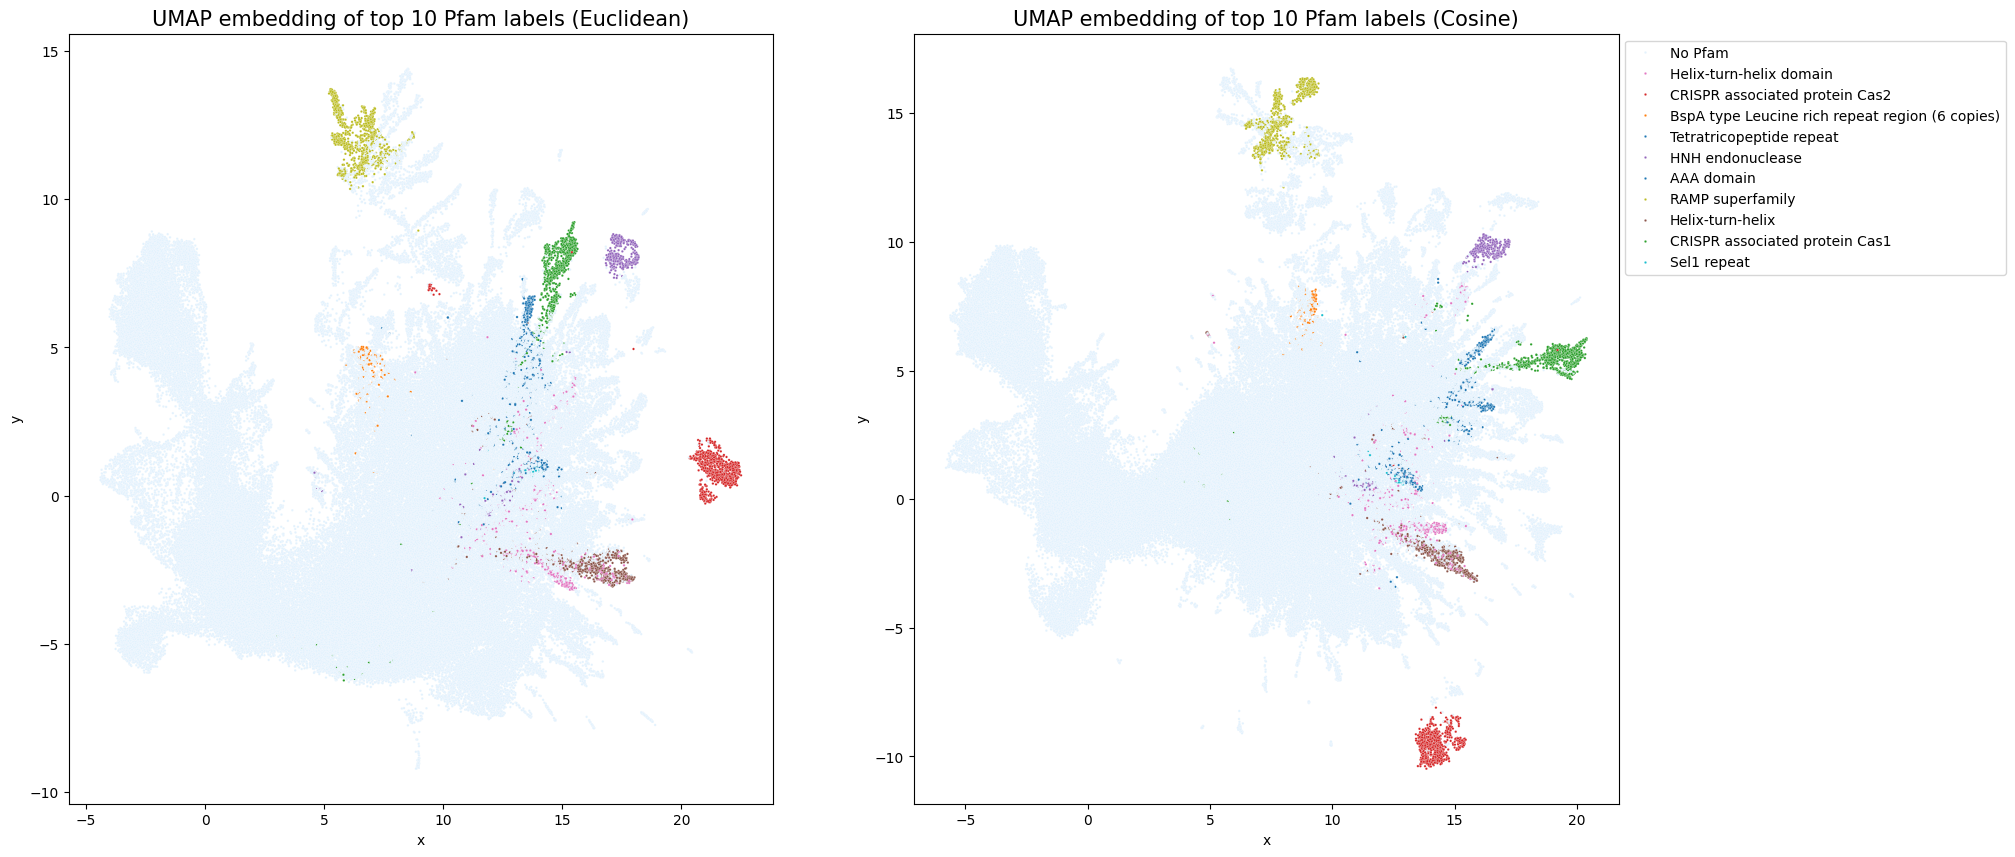

In [277]:

#get umap_df
umap_df_euc = pd.DataFrame(umap_embedding_euc,columns=['x','y'])
umap_df_cos = pd.DataFrame(umap_embedding_cos,columns=['x','y'])
umap_df_euc['type'] = deduplicated_df['Signature description']
umap_df_cos['type'] = deduplicated_df['Signature description']

umap_df_euc['id'] = deduplicated_df.index
umap_df_cos['id'] = deduplicated_df.index
#before drawing set parameters
labels = umap_df_euc['type'] #type is label
unique_labels = np.unique(labels)

# 生成基础调色板
base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))

# 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: ('#E3F2FD' if label == 'No Pfam' else base_palette[i]) for i, label in enumerate(unique_labels)}
# 将图例放置到右上角，且不介入图中
# 绘制散点图，使用更新的调色板
# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 绘制EUC的UMAP散点图
sns.scatterplot(x=umap_df_euc.x, y=umap_df_euc.y, hue=labels, palette=palette, s=3, ax=axes[0])
axes[0].set_title("UMAP embedding of top 10 Pfam labels (Euclidean)", fontsize=15)

# 生成COS数据的标签
labels_cos = umap_df_cos['type']

# 绘制COS的UMAP散点图
sns.scatterplot(x=umap_df_cos.x, y=umap_df_cos.y, hue=labels, palette=palette, s=3, ax=axes[1])
axes[1].set_title("UMAP embedding of top 10 Pfam labels (Cosine)", fontsize=15)

#去掉legend
axes[0].get_legend().remove()
axes[1].get_legend().remove()
#最右边画legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [11]:
#umap_df_euc = pd.read_csv('/mnt/yizhou/Data/Label/umap_all_embedding_euclidean_top_10_pfam.csv')
#umap_df_cos = pd.read_csv('/mnt/yizhou/Data/Label/umap_all_embedding_cosine_top_10_pfam.csv')
base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))
from matplotlib.colors import rgb2hex
# 为每个唯一标签创建颜色映射，对于 "No Pfam" 使用灰色，其他使用 "tab10" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: (rgb2hex('#E3F2FD') if label == 'No Pfam' else rgb2hex(base_palette[i])) for i, label in enumerate(unique_labels)}

palette_df = pd.DataFrame(palette.items(), columns=['type', 'node_color'])

merged_umap_euc = pd.merge(umap_df_euc, palette_df, on='type', how='left')
merged_umap_cos = pd.merge(umap_df_cos, palette_df, on='type', how='left')




# Task2 Statistics of embedding

## Prepare for Data


In [5]:
import pandas as pd
import sys
import os
from tqdm import tqdm
from Core.Utils.utils import *

total_interpro_df = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')
#load esm embedding and labels
esm_embedding, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding


#create df
esm_all_df = pd.DataFrame({
                        'Protein accession': esm_embedding_accession,
                        'esm_embedding':esm_embedding})
esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)



This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Label\total_fasta_interpro.tsv
This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Preparation_Data\total_esm3_normalized_embedding.pkl


## Subtask 2.1More details in local Cas protein/ Cluster for Cas1, Cas2, and together.

### First get proteins with label Cas1/2

In [4]:
import numpy as np
target_labels = ['CRISPR associated protein Cas1','CRISPR associated protein Cas2']
#get corresponding pfam
interpro_cas_all = total_interpro_df[total_interpro_df['Signature description'].isin(target_labels)]
interpro_cas_all = interpro_cas_all[interpro_cas_all['Analysis'] == 'Pfam']
#drop duplicated 
interpro_cas = interpro_cas_all.drop_duplicates(subset='Protein accession')
interpro_cas = interpro_cas.loc[:, ['Protein accession', 'Signature description']].reset_index(drop=True)

NameError: name 'total_interpro_df' is not defined

In [169]:
#merge with all esm
interpro_cas = pd.merge(interpro_cas,esm_all_df,how='left',on='Protein accession')
interpro_cas_embedding, interpro_cas_labels = np.vstack(interpro_cas.esm_embedding.values),np.vstack(interpro_cas.loc[:,'Signature description'].values)

### Then prepare for umap cas1/cas2/cas1&2


Cas1&2

In [142]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.5,
        'local_connectivity': 1,
        'random_state':42
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.5,
    'local_connectivity': 1,
    'random_state':42
}
umap_embedding_euc = get_umap_embeddings(interpro_cas_embedding,umap_config_euc)
umap_embedding_cos = get_umap_embeddings(interpro_cas_embedding,umap_config_cos)


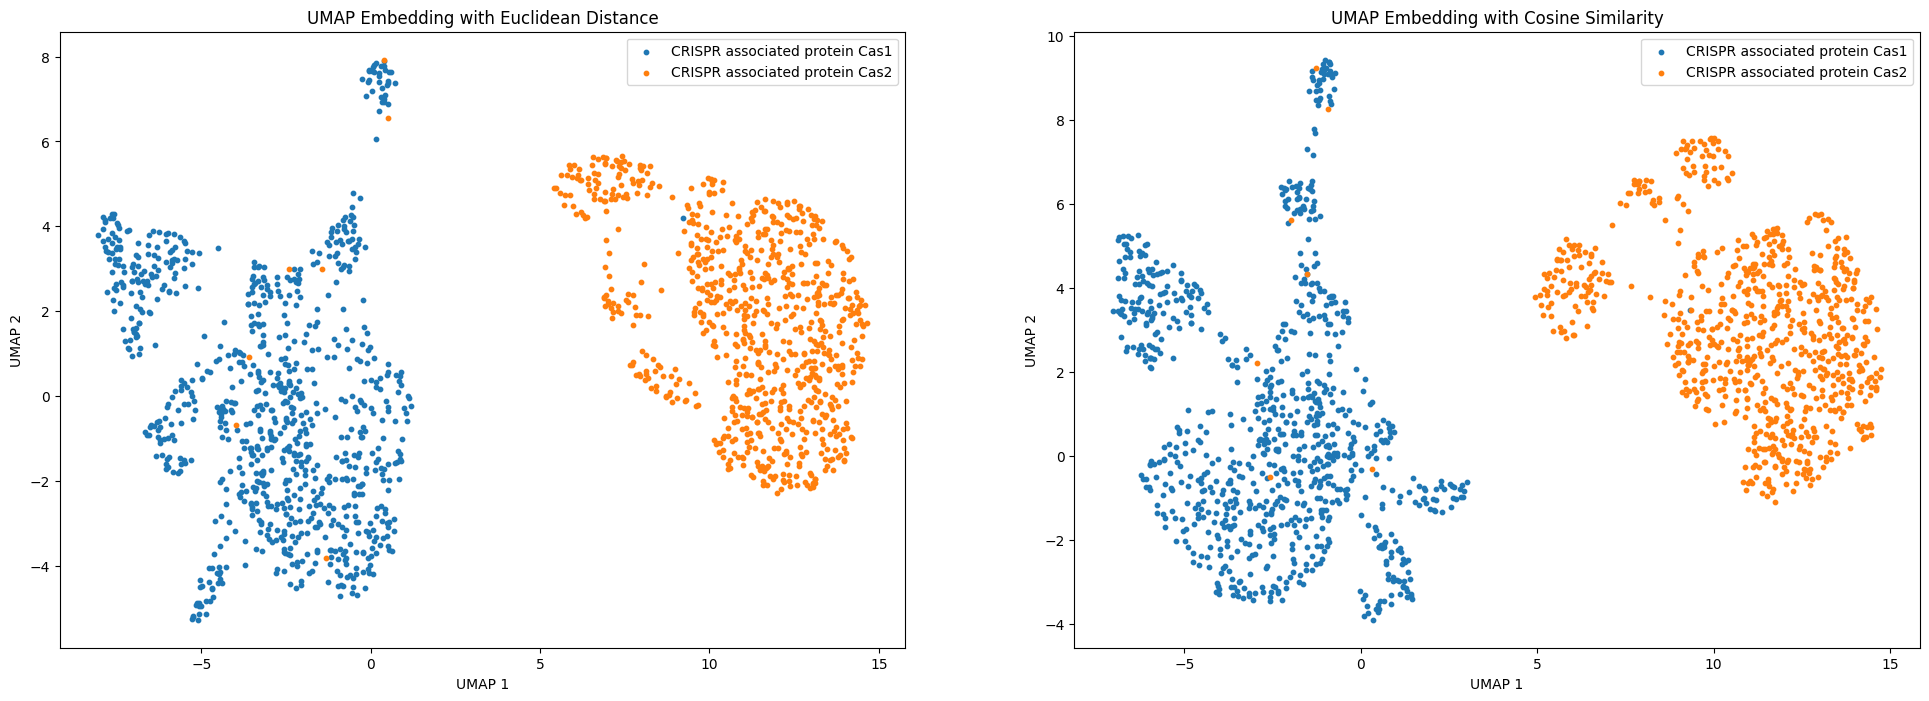

In [143]:
import matplotlib.pyplot as plt
umap_embedding_euc_df = creat_cosomo_embedding(umap_embedding_euc,interpro_cas_labels)
umap_embedding_cos_df = creat_cosomo_embedding(umap_embedding_cos,interpro_cas_labels)
plot_scatter_with_labels(umap_embedding_euc_df,umap_embedding_cos_df)

Cas1 only Umap

And add Ids of subcluster in umap of all embeddings

In [373]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.3,
        'local_connectivity': 1,
        'random_state':42
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.3,
    'local_connectivity': 1,
    'random_state':42
}
#get only cas1
interpro_cas1 = interpro_cas[interpro_cas['Signature description'] == 'CRISPR associated protein Cas1'].reset_index(drop=True)
interpro_cas1_embedding, interpro_cas1_labels = np.vstack(interpro_cas1.esm_embedding.values),np.vstack(interpro_cas1.loc[:,'Signature description'].values)
umap_embedding_cas1_euc = get_umap_embeddings(interpro_cas1_embedding,umap_config_euc)
umap_embedding_cas1_cos = get_umap_embeddings(interpro_cas1_embedding,umap_config_cos)

c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


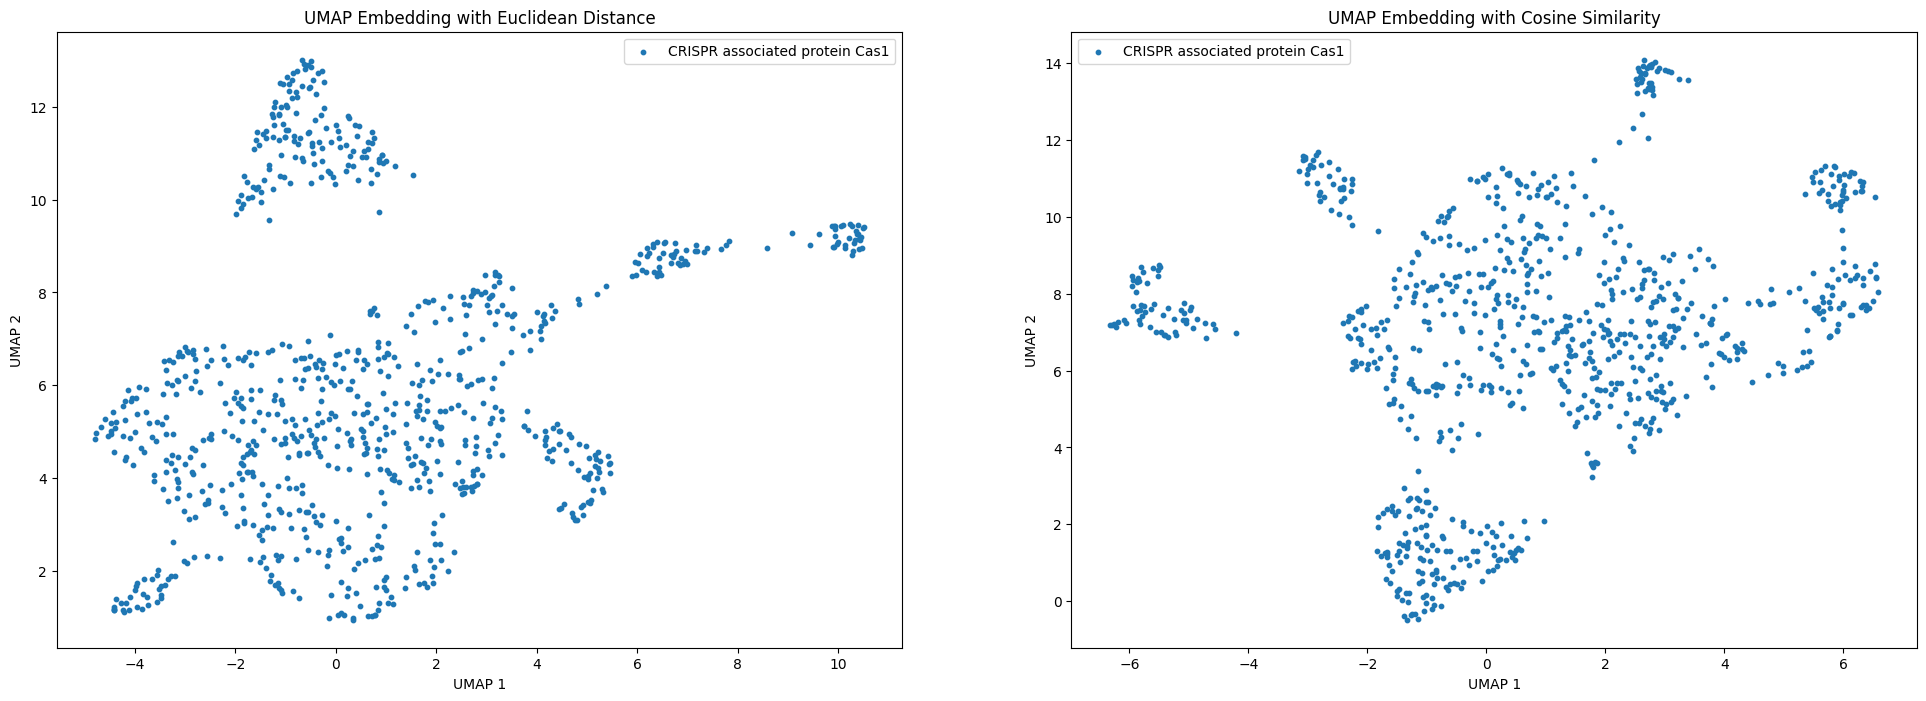

In [374]:
umap_embedding_cas1_euc_df = creat_cosomo_embedding(umap_embedding_cas1_euc,interpro_cas1_labels)
umap_embedding_cas1_cos_df = creat_cosomo_embedding(umap_embedding_cas1_cos,interpro_cas1_labels)
plot_scatter_with_labels(umap_embedding_cas1_euc_df,umap_embedding_cas1_cos_df)

Add ids of subcluster and show them in different colors

In [380]:
file = pd.read_csv('C:/Users/13330/Downloads/undefined-exported (3).csv',sep=';')
file.id.to_list()

[2577,
 13447,
 26474,
 26595,
 28451,
 29355,
 32361,
 41341,
 42259,
 42810,
 45182,
 45968,
 47257,
 50806,
 50909,
 54349,
 57326,
 60247,
 61665,
 63047,
 64588,
 71660,
 76287,
 83907,
 85417,
 85786,
 86570,
 87827,
 89601,
 91300,
 91453,
 95228,
 96884,
 106576,
 106843,
 107597,
 107603,
 109164,
 110754,
 112810,
 112962,
 113010,
 113033,
 113052,
 124023]

In [383]:
#get sorted esm all by protein accession
esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)
# get ids of subcluster of cas1 from cosmograph
cas1_subcluster_1_ids = [
    1221, 1389, 1638, 2184, 2235, 2522, 2585, 2622, 3645, 3823, 
    4214, 4405, 4490, 4516, 4845, 4848, 5045, 5531, 5567, 5656, 
    5727, 6565, 6628, 6979, 7275, 7365, 7585, 7626, 7715, 7875, 
    8180, 8241, 8265, 8344, 8541, 8680, 8748, 9091, 9099, 9292, 
    9417, 9642, 9739, 13177, 13396, 13433, 13500, 13514, 14558, 14748, 
    15023, 15131, 15510, 15597, 15661, 16132, 16224, 16797, 16839, 17003, 
    17055, 17068, 17280, 17378, 17469, 17697, 17714, 17759, 17764, 17774, 
    18126, 18334, 18577, 19438, 19581, 19649, 19895, 20223, 20619, 20768, 
    20844, 21088, 21231, 21392, 21476, 21481, 21494, 21721, 22170, 22865, 
    23296, 23409, 23511, 23761, 23807, 23827, 24005, 24196, 24526, 24973, 
    25177, 25192, 25402, 25625, 25750, 25904, 25976, 26039, 26101, 26205, 
    26739, 27073, 27464, 27636, 27645, 27753, 27786, 27799, 27990, 28505, 
    28805, 29022, 29044, 29233, 30138, 30159, 30598, 30642, 30780, 30843, 
    31136, 31152, 31180, 31498, 31562, 31568, 31604, 31628, 32170, 32283, 
    32425, 33105, 33124, 33323, 33380, 33498, 33530, 33678, 33790, 34126, 
    34307, 35033, 35106, 35524, 35612, 36043, 36886, 37103, 37214, 37402, 
    37494, 37723, 37883, 37984, 38146, 38337, 38503, 38965, 39092, 39405, 
    39811, 39826, 40045, 40115, 40170, 40173, 40222, 40296, 40354, 40536, 
    40588, 40969, 41225, 41273, 41274, 41583, 41655, 41783, 41881, 42303, 
    42305, 42344, 42390, 42514, 42727, 42852, 42856, 42936, 43026, 43491, 
    43634, 43757, 43894, 44137, 44185, 44200, 44368, 44752, 44785, 44823, 
    45162, 45213, 45309, 45549, 45730, 46272, 46281, 46292, 46300, 46864, 
    46936, 46947, 47241, 47390, 47556, 47783, 47963, 48238, 48281, 48284, 
    48312, 48413, 48597, 48889, 48908, 49150, 49243, 49315, 49369, 49515, 
    49849, 50000, 50293, 50663, 50676, 50712, 51052, 51122, 51136, 51176, 
    51323, 51658, 51820, 52079, 52155, 52369, 52534, 52572, 52583, 53283, 
    53711, 54326, 54683, 55248, 55323, 55527, 55800, 56012, 56242, 56657, 
    56866, 57809, 58825, 58931, 59158, 59338, 60473, 61095, 61878, 62040, 
    62539, 62693, 63183, 64553, 65369, 65469, 65811, 65958, 66264, 66275, 
    66333, 66508, 66568, 66849, 66868, 67128, 67264, 67285, 67845, 68088, 
    68620, 68960, 69125, 69189, 69681, 69867, 69898, 69969, 71624, 71767, 
    72101, 72359, 72411, 72522, 72541, 72677, 73029, 73146, 73244, 73463, 
    73698, 73725, 74600, 74604, 75061, 75380, 75388, 75583, 76266, 76288, 
    76996, 77004, 77160, 77622, 78152, 78195, 78272, 78494, 78546, 79101, 
    79131, 79254, 79674, 80040, 80401, 81011, 81049, 81145, 81281, 81356, 
    81603, 82087, 82373, 82552, 82574, 82617, 82819, 83050, 83051, 83096, 
    83205, 83211, 83257, 83290, 83308, 83333, 83510, 83885, 84059, 84193, 
    84367, 84481, 84601, 84612, 84642, 85071, 85191, 85387, 85409, 85416, 
    85717, 85718, 85725, 86019, 86035, 86115, 86119, 86444, 86468, 86540, 
    86585, 86606, 86638, 86639, 87546, 87774, 87858, 88014, 88656, 88865, 
    89005, 89084, 89233, 90010, 90028, 90038, 90496, 90672, 90918, 91096, 
    91163, 91176, 91233, 91316, 91491, 91644, 92615, 92813, 93043, 93386, 
    94045, 94090, 94108, 94158, 94189, 94630, 94761, 94799, 94811, 94837, 
    94839, 94849, 94884, 94912, 94970, 95262, 95271, 95280, 95296, 95306, 
    95433, 96335, 96368, 96573, 96833, 96867, 96910, 97074, 97329, 97370, 
    98808, 99671, 99956, 100136, 100686, 100970, 101028, 101045, 101482, 
    101694, 101856, 101925, 101977, 102204, 102412, 102574, 102592, 103402, 
    103629, 103753, 104220, 104753, 104833, 104837, 104984, 105500, 106079, 
    106814, 106842, 107039, 107127, 107412, 107604, 107670, 107727, 107828, 
    107977, 108025, 108154, 108340, 109163, 109304, 109339, 109836, 109956, 
    110012, 110055, 110163, 110177, 110705, 111033, 111125, 111506, 111525, 
    111598, 111704, 112102, 112159, 112180, 112233, 112493, 112557, 113121, 
    113128, 113246, 113549, 113795, 114303, 118222, 119056, 120277, 120393, 
    120544, 120837, 120897, 120917, 120920, 120968, 121069, 121469, 122123, 
    123808, 123987, 124118, 124380, 124471, 124484, 124561, 124612, 125058, 
    125168, 125687, 125964, 126459, 126526, 126651, 126773, 127094, 127239, 
    127564, 127577, 127606, 127770, 127980
]
cas1_subcluster_2_ids  = [
    314, 2379, 3105, 4143, 4155, 4429, 5003, 5583, 5617, 6053, 
    7395, 8075, 8284, 9098, 16120, 16605, 16609, 17316, 17384, 17520, 
    17805, 17935, 18373, 18382, 18751, 19482, 19932, 21315, 21599, 22215, 
    22780, 24992, 25206, 25228, 25852, 26059, 26408, 26963, 27025, 27030, 
    27991, 28170, 28215, 28943, 29094, 29226, 30352, 33057, 33228, 33539, 
    34097, 34165, 34864, 35995, 36137, 38608, 41325, 41844, 42004, 43715, 
    44202, 44789, 45448, 45546, 45845, 46242, 46329, 46830, 47534, 47881, 
    48732, 48766, 49378, 49631, 53323, 53443, 53616, 53729, 53821, 54333, 
    59896, 60083, 60219, 60862, 60947, 61481, 63863, 64016, 64095, 64538, 
    64688, 69127, 69396, 71972, 72530, 72779, 73045, 74638, 75495, 75572, 
    77840, 78257, 78500, 78712, 79382, 80171, 80802, 81770, 82282, 83572, 
    83674, 84420, 84707, 85216, 85287, 85727, 85811, 86644, 88150, 91282, 
    91456, 91590, 92807, 93866, 93882, 93960, 94808, 95410, 96832, 96883, 
    98439, 98615, 100597, 101499, 104969, 106670, 107174, 107688, 108438, 
    108801, 109027, 109247, 111049, 111168, 111832, 112582, 112916, 113524, 
    119994, 120381, 120383, 121731, 123154, 123158, 124530, 126375, 127539, 
    127594, 127667, 127672
]

cas1_subcluster_3_ids = [
    2577, 13447, 26474, 26595, 28451, 29355, 32361, 41341, 42259, 42810, 
    45182, 45968, 47257, 50806, 50909, 54349, 57326, 60247, 61665, 63047, 
    64588, 71660, 76287, 83907, 85417, 85786, 86570, 87827, 89601, 91300, 
    91453, 95228, 96884, 106576, 106843, 107597, 107603, 109164, 110754, 
    112810, 112962, 113010, 113033, 113052, 124023
]
cas1_subcluster_4_ids = [
    3988, 9107, 11695, 13345, 15165, 16472, 16775, 17639, 17960, 23644, 
    23850, 26085, 38712, 42561, 45325, 47880, 52925, 56506, 80098, 80800, 
    81654, 88987, 89853, 98112, 100713, 102426, 107729, 109791, 111235, 
    112099, 126646
]


cas1_subcluster_1_protein_accessions = esm_all_df.loc[cas1_subcluster_1_ids, 'Protein accession'].values
cas1_subcluster_2_protein_accessions = esm_all_df.loc[cas1_subcluster_2_ids, 'Protein accession'].values
cas1_subcluster_3_protein_accessions = esm_all_df.loc[cas1_subcluster_3_ids, 'Protein accession'].values
cas1_subcluster_4_protein_accessions = esm_all_df.loc[cas1_subcluster_4_ids, 'Protein accession'].values

interpro_cas1['Cluster'] = interpro_cas1.apply(lambda x: '1' if x['Protein accession'] in cas1_subcluster_1_protein_accessions 
                                             else '2' if x['Protein accession'] in cas1_subcluster_2_protein_accessions
                                             else '3' if x['Protein accession'] in cas1_subcluster_3_protein_accessions
                                             else '4' if x['Protein accession'] in cas1_subcluster_4_protein_accessions
                                             else '0', axis=1)

umap_embedding_cas1_euc_df['Cluster'] = interpro_cas1['Cluster']
umap_embedding_cas1_cos_df['Cluster'] = interpro_cas1['Cluster']

Add these subcluster colors into the umap plot


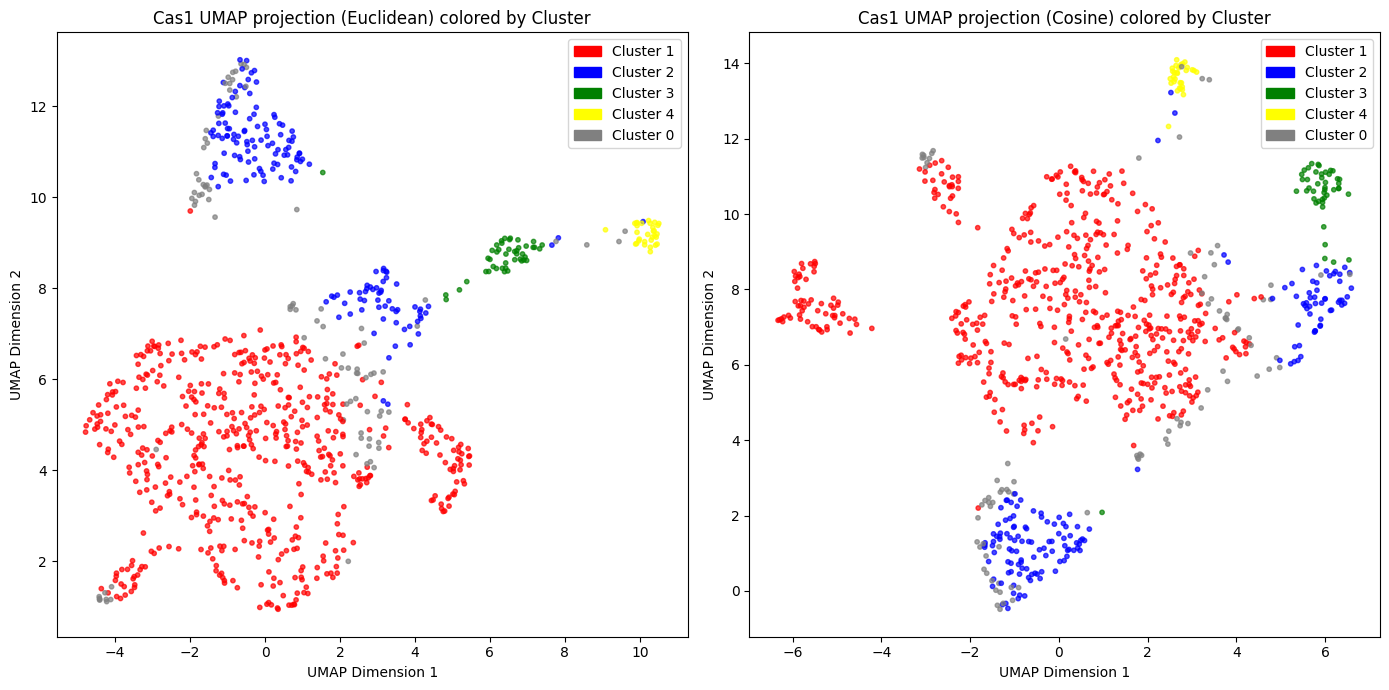

In [385]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define color map for clusters
cluster_colors = {'0': 'gray', '1': 'red', '2': 'blue','3':'green','4':'yellow'}  # Adjust colors as needed

# Map the 'Cluster' column to colors
colors_euc = umap_embedding_cas1_euc_df['Cluster'].map(cluster_colors)
colors_cos = umap_embedding_cas1_cos_df['Cluster'].map(cluster_colors)

# Create legend handles
legend_handles = [
    mpatches.Patch(color='red', label='Cluster 1'),
    mpatches.Patch(color='blue', label='Cluster 2'),
    mpatches.Patch(color='green', label='Cluster 3'),
    mpatches.Patch(color='yellow', label='Cluster 4'),
    mpatches.Patch(color='gray', label='Cluster 0')
]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # Adjust the figsize as needed

# Plotting the UMAP embedding based on Euclidean distance (left)
ax[0].scatter(umap_embedding_cas1_euc_df['x'], umap_embedding_cas1_euc_df['y'], 
              c=colors_euc, s=10, alpha=0.7)
ax[0].set_title('Cas1 UMAP projection (Euclidean) colored by Cluster')
ax[0].set_xlabel('UMAP Dimension 1')
ax[0].set_ylabel('UMAP Dimension 2')
ax[0].legend(handles=legend_handles)  # Add the legend here

# Plotting the UMAP embedding based on Cosine similarity (right)
ax[1].scatter(umap_embedding_cas1_cos_df['x'], umap_embedding_cas1_cos_df['y'], 
              c=colors_cos, s=10, alpha=0.7)
ax[1].set_title('Cas1 UMAP projection (Cosine) colored by Cluster')
ax[1].set_xlabel('UMAP Dimension 1')
ax[1].set_ylabel('UMAP Dimension 2')
ax[1].legend(handles=legend_handles)  # Add the legend here

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


Cas2

In [170]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.3,
        'local_connectivity': 1,
        'random_state':42
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.3,
    'local_connectivity': 1,
    'random_state':42
}
#get only cas1
interpro_cas2 = interpro_cas[interpro_cas['Signature description'] == 'CRISPR associated protein Cas2'].reset_index(drop=True)
interpro_cas2_embedding, interpro_cas2_labels = np.vstack(interpro_cas2.esm_embedding.values),np.vstack(interpro_cas2.loc[:,'Signature description'].values)
umap_embedding_cas2_euc = get_umap_embeddings(interpro_cas2_embedding,umap_config_euc)
umap_embedding_cas2_cos = get_umap_embeddings(interpro_cas2_embedding,umap_config_cos)



c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


NameError: name 'interpro_cas1' is not defined

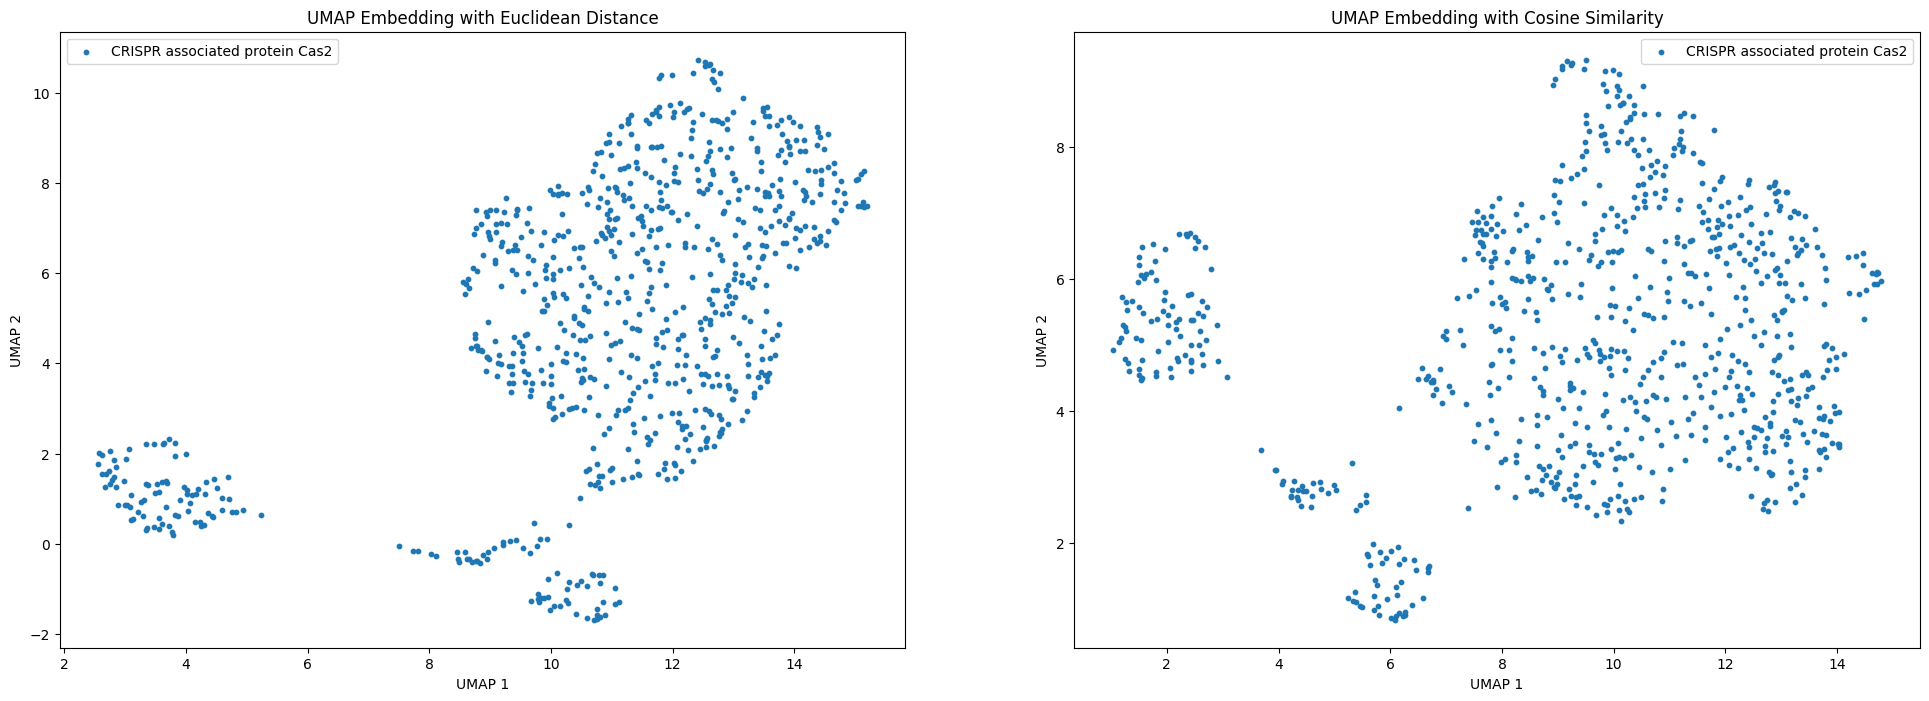

In [349]:
umap_embedding_cas2_euc_df = creat_cosomo_embedding(umap_embedding_cas2_euc,interpro_cas2_labels)
umap_embedding_cas2_cos_df = creat_cosomo_embedding(umap_embedding_cas2_cos,interpro_cas2_labels)
plot_scatter_with_labels(umap_embedding_cas2_euc_df,umap_embedding_cas2_cos_df)

Add ids of subcluster and show them in different colors


In [354]:
#get sorted esm all by protein accession
# get ids of subcluster of cas1 from cosmograph
cas2_subcluster_1_ids = [
    2988, 3210, 4377, 4906, 4944, 6679, 15396, 20994, 23653, 28090, 
    28982, 30190, 36979, 40399, 58255, 67645, 82455, 86586, 87406, 
    88217, 91705, 100245, 111583, 121072
]

cas2_subcluster_2_ids =  [
    121, 2703, 3569, 8113, 9466, 14258, 15122, 15301, 16223, 17029, 17163, 17297, 
    18890, 19184, 19559, 20663, 22609, 22662, 24345, 24821, 26639, 31084, 33887, 
    35943, 38420, 38781, 39046, 39131, 40316, 40791, 41653, 42495, 42746, 42756, 
    43175, 44892, 45800, 48210, 49100, 49596, 51999, 56613, 56956, 57552, 58167, 
    58598, 59661, 60121, 60246, 61407, 61518, 62471, 66037, 67014, 78096, 81641, 
    83130, 84988, 85242, 85475, 85502, 85548, 86506, 89217, 91769, 92087, 95275, 
    98156, 100148, 103708, 103852, 104513, 105351, 106006, 107533, 109971, 112849, 
    114481, 120344, 121035, 121625, 122251, 122260, 124994, 125165, 127964
]

cas2_subcluster_3_ids = [
    192, 310, 697, 1647, 1782, 1926, 1929, 2728, 2746, 3146, 3760, 4254, 4465, 4623, 4698, 4748, 4760, 4779, 4796, 
    4797, 4835, 4873, 5501, 5543, 6586, 6802, 6839, 7133, 7233, 7243, 7265, 7323, 7326, 7676, 7724, 8924, 9451, 
    9548, 9691, 12548, 12953, 12975, 12990, 13190, 13363, 13382, 13406, 13431, 13448, 13457, 13495, 13506, 13922, 
    14098, 15062, 15116, 15554, 16047, 17411, 17642, 17977, 18396, 18466, 18581, 18802, 18807, 19009, 19173, 20290, 
    20366, 20651, 20655, 20776, 21074, 21078, 21106, 21282, 21394, 21518, 21631, 21645, 22037, 22341, 23086, 23099, 
    23219, 23293, 23960, 24128, 24188, 24545, 24571, 24597, 24786, 25215, 26378, 26492, 26802, 26917, 27410, 27806, 
    28338, 28446, 28712, 28777, 28853, 29062, 29519, 30525, 30738, 30752, 31061, 31404, 31470, 31591, 31592, 31594, 
    31634, 31740, 31768, 31782, 31996, 32264, 32301, 32364, 32903, 34994, 35622, 35639, 35641, 36070, 36728, 37090, 
    37235, 37332, 37603, 37644, 37798, 38223, 38260, 38342, 38350, 38560, 38598, 38697, 38970, 39049, 39128, 39194, 
    39359, 39433, 39535, 39583, 39622, 39688, 39929, 40064, 40193, 40227, 40436, 40555, 40975, 40984, 41157, 41178, 
    41272, 41277, 41340, 41843, 42247, 42302, 42328, 42340, 42389, 42415, 42630, 42813, 42847, 42926, 42940, 43029, 
    43044, 43169, 43530, 43535, 43544, 43711, 43797, 43888, 43973, 43980]




cas2_subcluster_1_protein_accessions = esm_all_df.loc[cas2_subcluster_1_ids, 'Protein accession'].values
cas2_subcluster_2_protein_accessions = esm_all_df.loc[cas2_subcluster_2_ids, 'Protein accession'].values
cas2_subcluster_3_protein_accessions = esm_all_df.loc[cas2_subcluster_3_ids, 'Protein accession'].values


interpro_cas2['Cluster'] = interpro_cas2.apply(lambda x: '1' if x['Protein accession'] in cas2_subcluster_1_protein_accessions 
                                             else '2' if x['Protein accession'] in cas2_subcluster_2_protein_accessions
                                             else '3' if x['Protein accession'] in cas2_subcluster_3_protein_accessions
                                             else '0', axis=1)

umap_embedding_cas2_euc_df['Cluster'] = interpro_cas2['Cluster']
umap_embedding_cas2_cos_df['Cluster'] = interpro_cas2['Cluster']

add these in umap plot

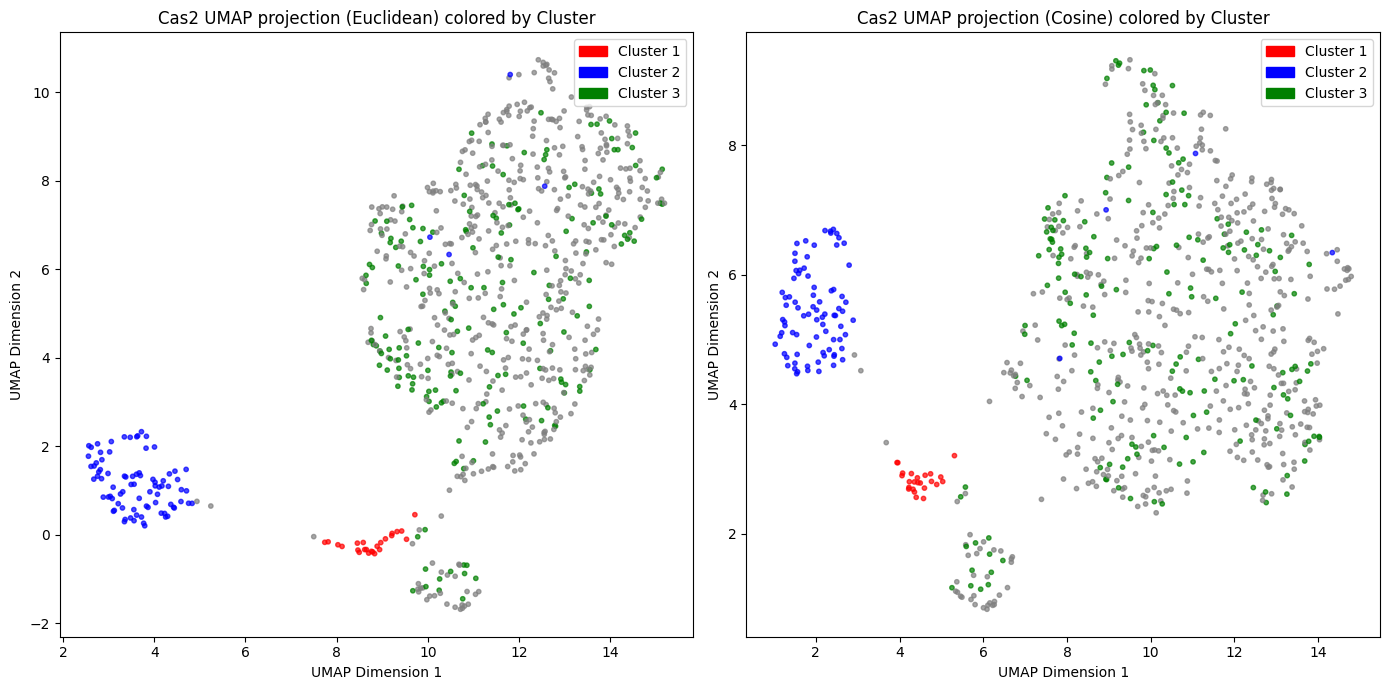

In [358]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define color map for clusters
cluster_colors = {'0':'gray','1': 'red', '2': 'blue','3': 'green'}  # Adjust colors as needed

# Map the 'Cluster' column to colors
colors_euc = umap_embedding_cas2_euc_df['Cluster'].map(cluster_colors)
colors_cos = umap_embedding_cas2_cos_df['Cluster'].map(cluster_colors)

# Create legend handles
legend_handles = [
    mpatches.Patch(color='red', label='Cluster 1'),
    mpatches.Patch(color='blue', label='Cluster 2'),
    mpatches.Patch(color='green', label='Cluster 3')
]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # Adjust the figsize as needed

# Plotting the UMAP embedding based on Euclidean distance (left)
ax[0].scatter(umap_embedding_cas2_euc_df['x'], umap_embedding_cas2_euc_df['y'], 
              c=colors_euc, s=10, alpha=0.7)
ax[0].set_title('Cas2 UMAP projection (Euclidean) colored by Cluster')
ax[0].set_xlabel('UMAP Dimension 1')
ax[0].set_ylabel('UMAP Dimension 2')
ax[0].legend(handles=legend_handles)  # Add the legend here

# Plotting the UMAP embedding based on Cosine similarity (right)
ax[1].scatter(umap_embedding_cas2_cos_df['x'], umap_embedding_cas2_cos_df['y'], 
              c=colors_cos, s=10, alpha=0.7)
ax[1].set_title('Cas2 UMAP projection (Cosine) colored by Cluster')
ax[1].set_xlabel('UMAP Dimension 1')
ax[1].set_ylabel('UMAP Dimension 2')
ax[1].legend(handles=legend_handles)  # Add the legend here

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


Does the seqs in mixed cluster include multiple labels? 

In [11]:
idx = umap_config_euc_df[(umap_config_euc_df.x > 10) & (umap_config_euc_df.x < 16)].index
interpro_cas.iloc[idx,]
duplicate_sequences = interpro_cas_all[interpro_cas_all.duplicated('Protein accession', keep=False)]


NameError: name 'umap_config_euc_df' is not defined

In [164]:
set_duplicated = set(duplicate_sequences.loc[:,'Protein accession'])
set_odd_cluster = set(interpro_cas.iloc[idx,].loc[:,'Protein accession'])

set_duplicated.intersection(set_odd_cluster)

{'IMG_3300010960&&Ga0137307_100805&&29133_29742_1'}

## Subtask 2.2Number of multiple labels

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming total_interpro_df is already defined
total_interpro_pfam = total_interpro_df[total_interpro_df['Analysis'] == 'Pfam']
# Count the number of labels for each sequence
label_counts = total_interpro_pfam['Protein accession'].value_counts()

# Filter sequences with more than one label
multiple_label_counts = label_counts[label_counts > 1]

# Draw histogram plot distribution of multiple label counts with log scale
plt.figure(figsize=(10, 6))
plt.hist(multiple_label_counts, bins=range(2, multiple_label_counts.max() + 2), edgecolor='black', log=True)
plt.title('Distribution of Sequences with Multiple annotations')
plt.xlabel('Number of annotations')
plt.ylabel('Frequency')

# Set x-axis ticks with an interval of 5
plt.xticks(range(2, multiple_label_counts.max() + 2, 5))

plt.show()

NameError: name 'total_interpro_df' is not defined

## Does the embedding distribute randomly?

Frist check label distribution

distribution of each label, found >5000 labels only occure once


Most labels only appear once!

C:\Users\13330\AppData\Local\Temp\ipykernel_30872\3205448212.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




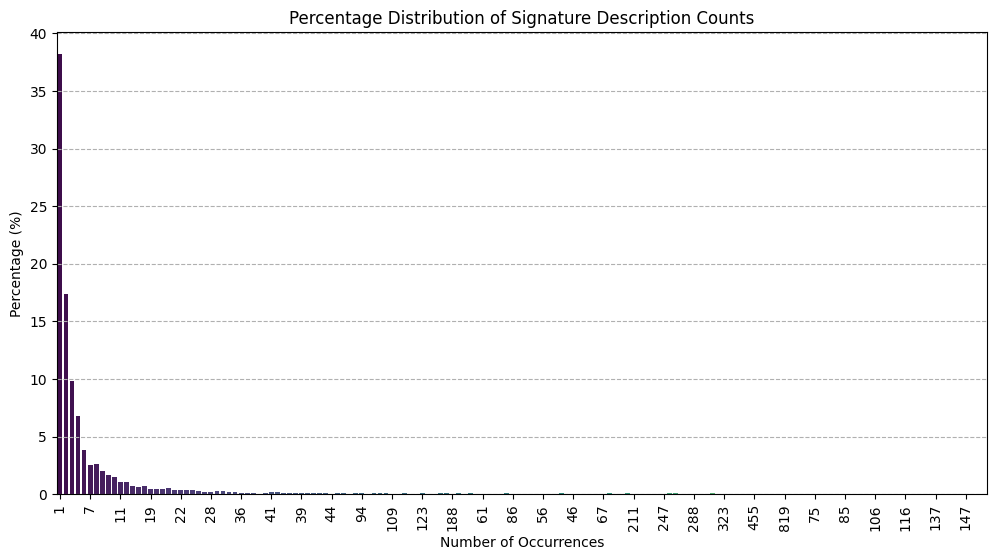

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming total_interpro_pfam is your DataFrame
# Get the counts of each Signature description
signature_counts = total_interpro_pfam['Signature description'].value_counts()

# Get the counts of the occurrence frequencies
occurrence_counts = signature_counts.value_counts()

# Convert the counts to percentages
percentage_counts = (occurrence_counts / occurrence_counts.sum()) * 100

# Plot the distribution using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=percentage_counts.index, y=percentage_counts.values, palette="viridis")
plt.title('Percentage Distribution of Signature Description Counts')
plt.xlabel('Number of Occurrences')
plt.ylabel('Percentage (%)')

# Show only every 5th label on the x-axis
plt.xticks(ticks=range(0, len(percentage_counts.index), 5), 
           labels=percentage_counts.index[::5], 
           rotation=90)

plt.grid(True, axis='y', linestyle='--')
plt.show()


In [10]:
# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]
#plot
import plotly
import plotly.express as px

# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]

# Create a DataFrame for plotting
df = filtered_signature_counts.reset_index()
df.columns = ['Label', 'Count']

# Plot using Plotly
fig = px.bar(df, x='Label', y='Count', title='Label Occurrences', labels={'Label': 'Label', 'Count': 'Occurrences'})

# Show the plot
fig.show()

In [11]:


# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]

# Create a DataFrame for plotting
df = filtered_signature_counts.reset_index()
df.columns = ['Label', 'Count']

# Plot using Plotly
fig = px.bar(df, x='Label', y='Count', title='Label Occurrences', labels={'Label': 'Label', 'Count': 'Occurrences'})

# Show the plot
fig.show()

## Subtask2.3Pair-wise within group distance


First get seqs info with single label 

In [316]:
#get interpro of pfam
total_interpro_pfam = total_interpro_df[total_interpro_df['Analysis'] == 'Pfam']
#embedding df
#umap_esm_euc_embedding = UmapEmbedding(work_path).esm3_umap_euc ################need to solve
umap_esm_euc_embedding_df = pd.read_csv('./Output/ESM/ESM_Embedding_Cosmograph/esm_3_umap_all_embedding_euclidean_top_10_pfam.csv')
# add Protein accession
umap_esm_euc_embedding_df['Protein accession'] = sorted(esm_embedding_accession)
#only keep protein id with single pfam label
single_pfam_label_interpro_df = total_interpro_pfam.groupby('Protein accession').filter(lambda x: len(x) == 1).loc[:,['Protein accession','Signature description']]
umap_esm_euc_single_pfam_label = pd.merge(umap_esm_euc_embedding_df, single_pfam_label_interpro_df, 
                     on='Protein accession', how='inner')
multiple_pfam_label_interpro_df = total_interpro_pfam.groupby('Protein accession').filter(lambda x: len(x) > 1).loc[:,['Protein accession','Signature description']]

umap_esm_euc_multiple_pfam_label = pd.merge(umap_esm_euc_embedding_df, multiple_pfam_label_interpro_df, 
                     on='Protein accession', how='inner')

Keep labels that are larger than the threshold

In [318]:
#should filter by whole dataset, as some labels might only occur in multiple labels.
threshold = 200
filter_labels = total_interpro_pfam.groupby('Signature description').filter(lambda x: len(x) >= threshold)
print('Total number of labels that are largerthan the threshold:',len(filter_labels['Signature description'].unique()))
filtered_signature_descriptions = filter_labels['Signature description'].unique()
single_filter_pfam_label_interpro_df = single_pfam_label_interpro_df[single_pfam_label_interpro_df['Signature description'].isin(filtered_signature_descriptions)]

Total number of labels that are largerthan the threshold: 35


C:\Users\13330\AppData\Local\Temp\ipykernel_30872\950728109.py:66: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\13330\AppData\Local\Temp\ipykernel_30872\950728109.py:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




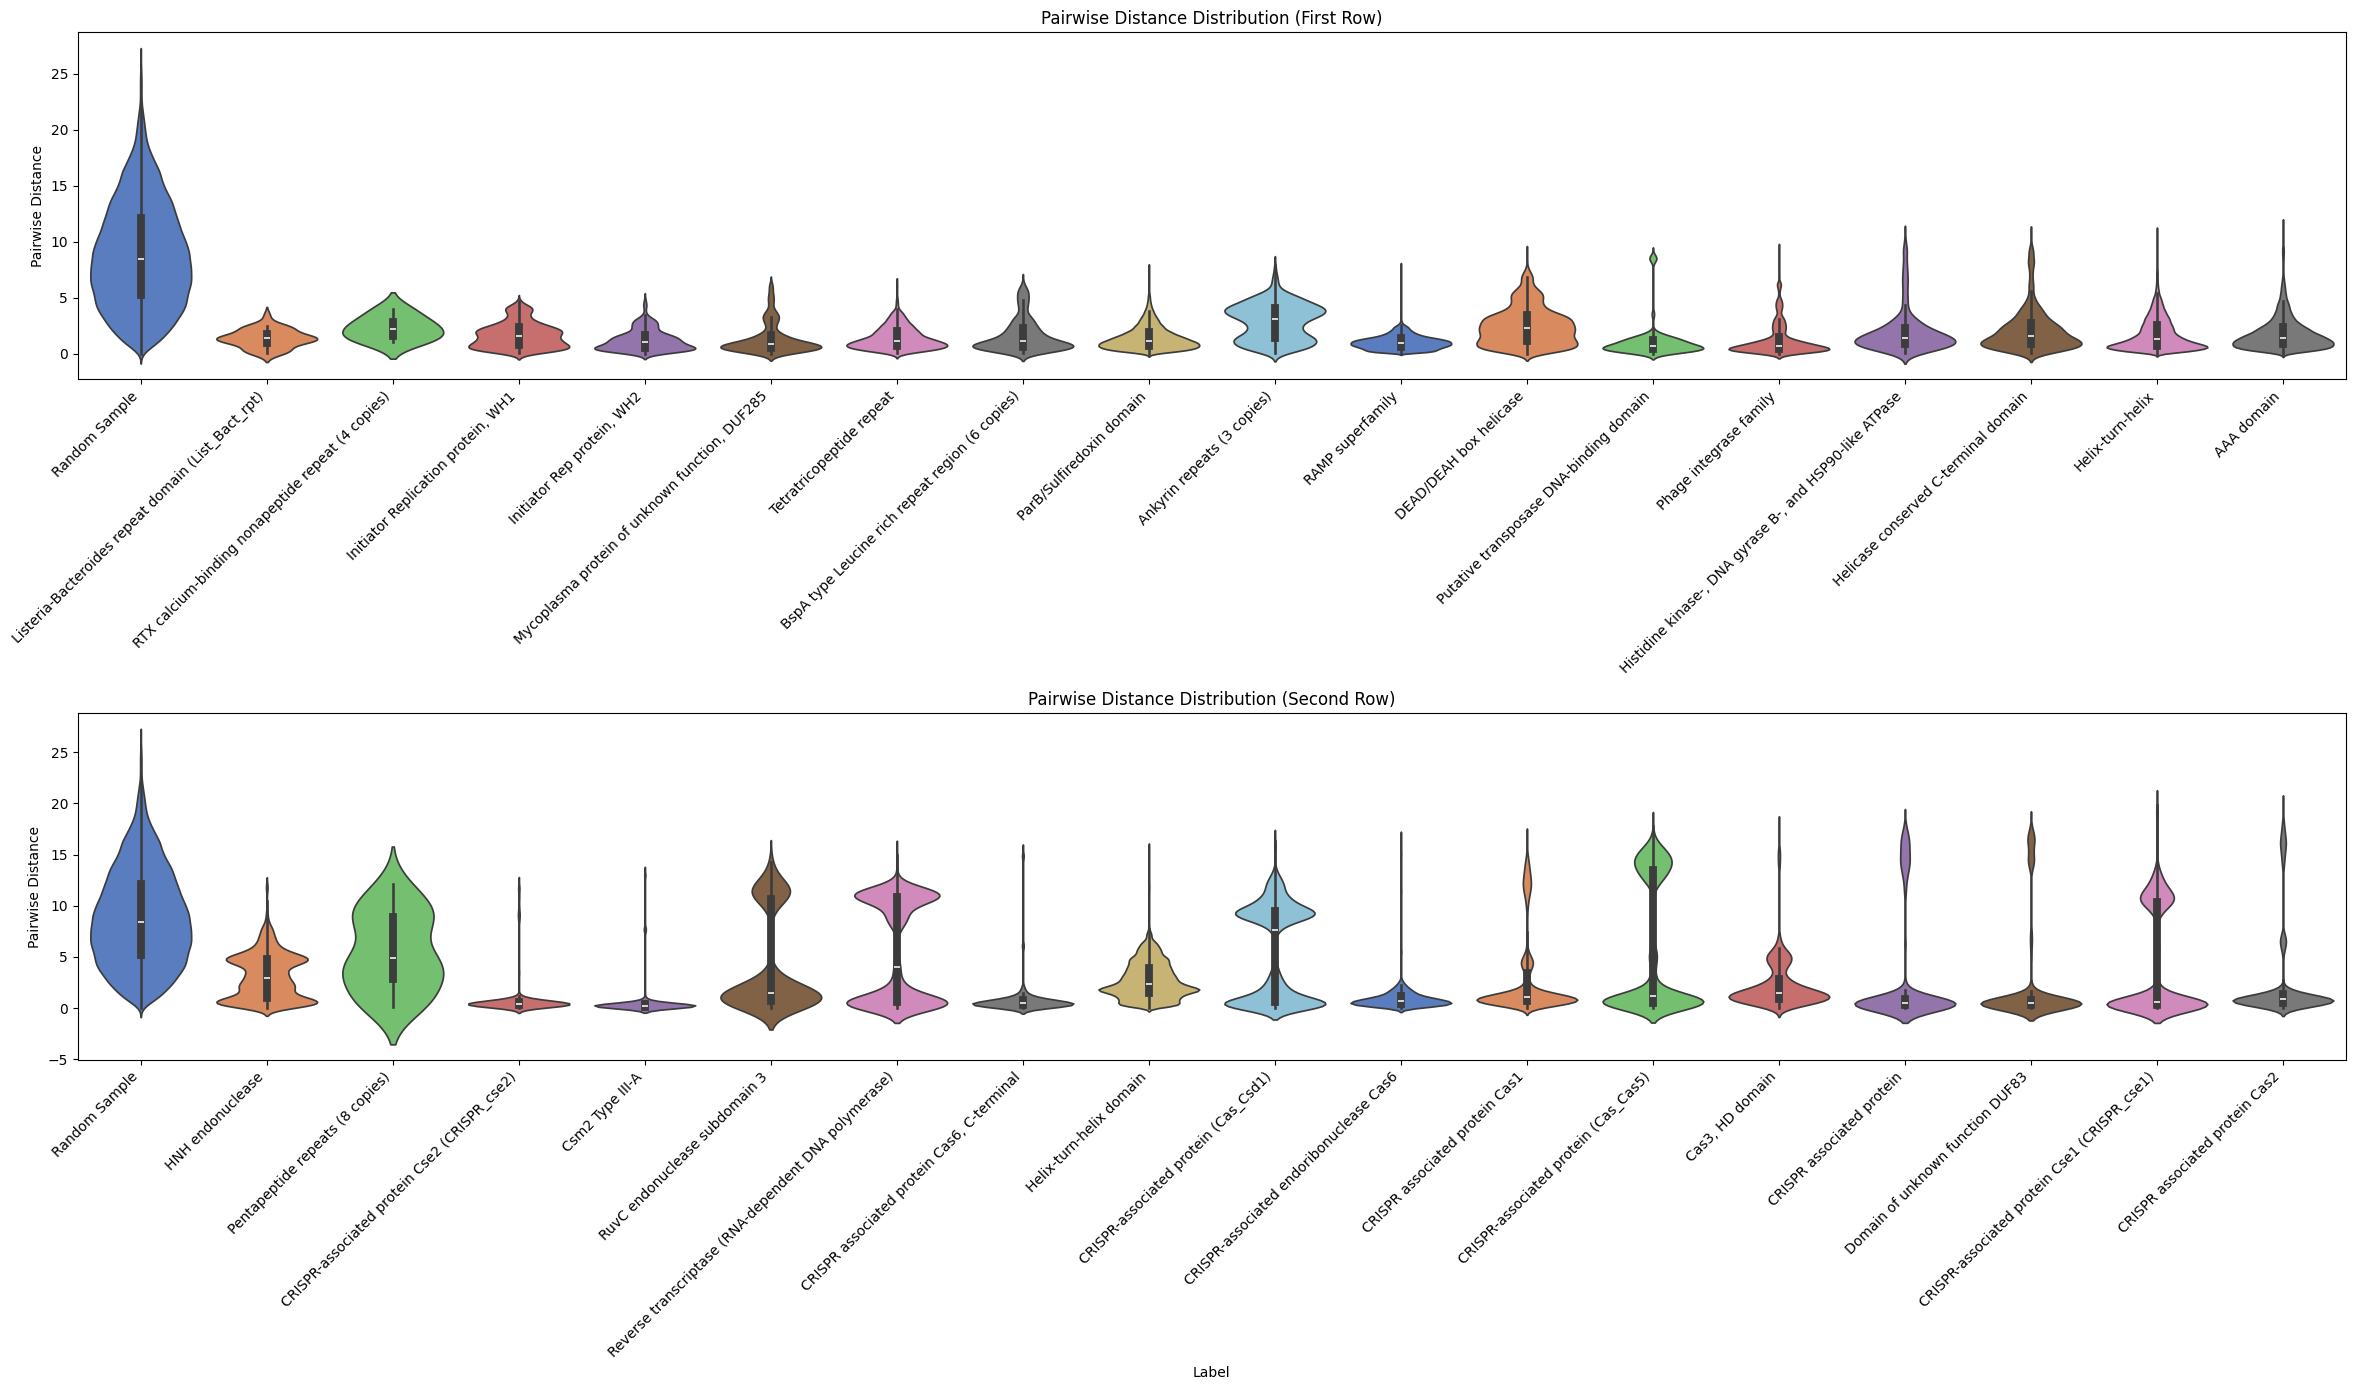

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Function to calculate pairwise distances
def calculate_pair_wise_distance(group):
    """
    Args:
    - group: DataFrame containing 'x', 'y' columns
    
    Returns:
    - distance_matrix: Squareform matrix of pairwise distances
    """
    embeddings = group[['x', 'y']].values
    pairwise_distances = pdist(embeddings, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    return distance_matrix

# Randomly sample 500 points from the dataset
sampled_data = umap_df_euc.sample(n=500, random_state=42)

# Calculate pairwise distances for the random sample
distance_matrix = calculate_pair_wise_distance(sampled_data)

# Extract the upper triangular matrix (excluding the diagonal)
upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]

# Store the distance values in a DataFrame with a 'Random Sample' label
baseline_data = pd.DataFrame({'Distance': upper_triangle_values, 'Label': 'Random Sample'})

# Group by label and calculate pairwise distances for each group
test_set = umap_esm_euc_filter_single_pfam_label
grouped = test_set.groupby('Signature description')

# Collect all upper triangle distance values and add a label for each group
data = []
max_ranges = {}

for label, group in grouped:
    distance_matrix = calculate_pair_wise_distance(group)
    # Extract the upper triangular matrix (excluding the diagonal)
    upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    if len(upper_triangle_values) > 0:  # Ensure the data is not empty
        data.append(pd.DataFrame({'Distance': upper_triangle_values, 'Label': label}))
        max_ranges[label] = upper_triangle_values.max()

# Combine all data into a single DataFrame
plot_data = pd.concat(data)

# Add the random sample data to the plot data
plot_data = pd.concat([baseline_data, plot_data])

# Sort labels by maximum distance value
sorted_labels = sorted(max_ranges.keys(), key=lambda x: max_ranges[x])

# Split sorted labels into two groups and add 'Random Sample' at the beginning of each
labels_group_1 = ['Random Sample'] + sorted_labels[:len(sorted_labels)//2]
labels_group_2 = ['Random Sample'] + sorted_labels[len(sorted_labels)//2:]

# Create the plot with two rows
fig, axes = plt.subplots(2, 1, figsize=(24, 14))  # Increased figure size for better spacing

# First row: Plot the first group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)], 
               order=labels_group_1, inner="box", palette="muted", ax=axes[0])
axes[0].set_title("Pairwise Distance Distribution (First Row)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Pairwise Distance")
axes[0].set_xticks(np.arange(len(labels_group_1)))  # Ensure correct number of ticks
axes[0].set_xticklabels(labels_group_1, rotation=45, ha='right')  # Correct rotation and alignment

# Second row: Plot the second group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)], 
               order=labels_group_2, inner="box", palette="muted", ax=axes[1])
axes[1].set_title("Pairwise Distance Distribution (Second Row)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Pairwise Distance")
axes[1].set_xticks(np.arange(len(labels_group_2)))  # Ensure correct number of ticks
axes[1].set_xticklabels(labels_group_2, rotation=45, ha='right')  # Correct rotation and alignment

# Adjust layout
plt.tight_layout()
plt.show()


Draw within group pair wise distances

In [ ]:
single_filter_pfam_Cas_interpro_df = single_filter_pfam_label_interpro_df[single_filter_pfam_label_interpro_df['Signature description'].isin(['CRISPR associated protein Cas1','CRISPR associated protein Cas2'])]
# Perform the merge operation on 'Protein accession'
umap_esm_euc_single_filter_pfam_Cas_label = pd.merge(single_filter_pfam_Cas_interpro_df[['Protein accession','Signature description']],
                     umap_esm_euc_single_pfam_label[['Protein accession', 'x', 'y']],
                     how='inner', 
                     on='Protein accession')

grouped = umap_esm_euc_single_filter_pfam_Cas_label.groupby('Signature description')

# Collect all upper triangle distance values and add a label for each group
data = []
max_ranges = {}

for label, group in grouped:
    distance_matrix = calculate_pair_wise_distance(group)
    # Extract the upper triangular matrix (excluding the diagonal)
    upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    if len(upper_triangle_values) > 0:  # Ensure the data is not empty
        data.append(pd.DataFrame({'Distance': upper_triangle_values, 'Label': label}))
        max_ranges[label] = upper_triangle_values.max()

# Combine all data into a single DataFrame
plot_data = pd.concat(data)

# Add the random sample data to the plot data
plot_data = pd.concat([baseline_data, plot_data])

# Sort labels by maximum distance value
sorted_labels = sorted(max_ranges.keys(), key=lambda x: max_ranges[x])

# Split sorted labels into two groups and add 'Random Sample' at the beginning of each
labels_group_1 = ['Random Sample'] + sorted_labels[:len(sorted_labels)//2]
labels_group_2 = ['Random Sample'] + sorted_labels[len(sorted_labels)//2:]

# Create the plot with two rows
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# First row: Plot the first group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)], 
               order=labels_group_1, inner="box", palette="muted", ax=axes[0])
axes[0].set_title("Pairwise Distance Distribution (First Row)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Pairwise Distance")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Second row: Plot the second group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)], 
               order=labels_group_2, inner="box", palette="muted", ax=axes[1])
axes[1].set_title("Pairwise Distance Distribution (Second Row)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Pairwise Distance")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

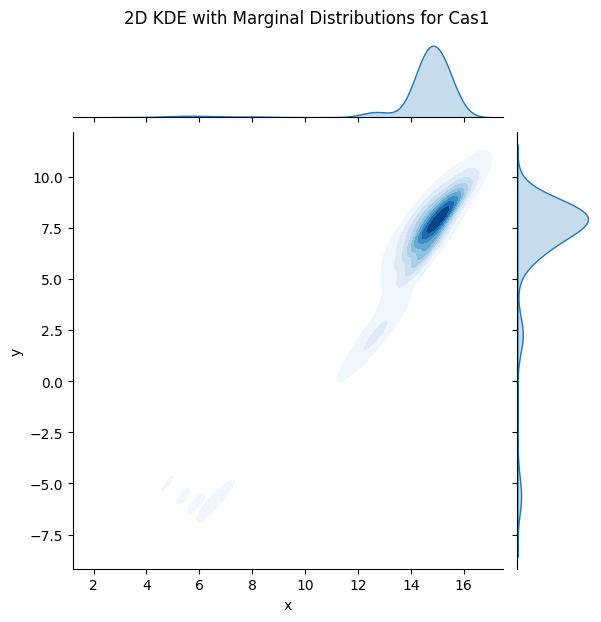

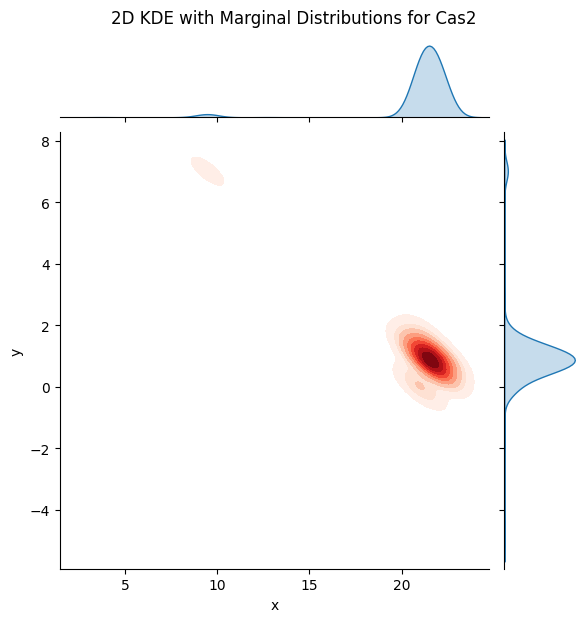

In [322]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'umap_esm_euc_single_filter_pfam_Cas_label'
df = umap_esm_euc_single_filter_pfam_Cas_label

# Filter data for Cas1 and Cas2
cas1_df = df[df['Signature description'] == 'CRISPR associated protein Cas1']
cas2_df = df[df['Signature description'] == 'CRISPR associated protein Cas2']

# 2D KDE plot with marginal KDEs for Cas1
plt.figure(figsize=(12, 10))

g1 = sns.jointplot(
    x=cas1_df['x'], 
    y=cas1_df['y'], 
    kind="kde", 
    cmap="Blues", 
    fill=True, 
    bw_adjust=1,  # Adjust this parameter to control smoothness
    marginal_kws=dict(fill=True)  # Adds marginal KDEs
)
g1.fig.suptitle('2D KDE with Marginal Distributions for Cas1', y=1.03)

# 2D KDE plot with marginal KDEs for Cas2
g2 = sns.jointplot(
    x=cas2_df['x'], 
    y=cas2_df['y'], 
    kind="kde", 
    cmap="Reds", 
    fill=True, 
    bw_adjust=1,  # Adjust this parameter to control smoothness
    marginal_kws=dict(fill=True)  # Adds marginal KDEs
)
g2.fig.suptitle('2D KDE with Marginal Distributions for Cas2', y=1.03)

plt.show()


## Subtask2.4 Cas* proteins statistics


In [5]:
from Bio import SeqIO
import pandas as pd

In [28]:
environment_path = work_path.environment_path
fasta_folder = 'Data/'
fasta_file_path = search_csv_file(environment_path,fasta_folder,'total.fasta')
# Define lists to store sequence names and lengths
sequence_names = []
sequence_lengths = []

# Read the FASTA file
with open(fasta_file_path) as fasta_file:
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence_names.append(record.id)  # Extract the sequence name
        sequence_lengths.append(len(record.seq))  # Extract the sequence length

# Create a DataFrame contain protein accession & length
fasta_all_df = pd.DataFrame({
    "Protein accession": sequence_names,
    "Length": sequence_lengths
})

total_interpro_pfam_folder = 'Shenzhen_GLM_Project/'
total_interpro_pfam_path = search_csv_file(environment_path,total_interpro_pfam_folder,'total_interpro_pfam.csv')

#read total_interpro_pfam
total_interpro_pfam_df = pd.read_csv(total_interpro_pfam_path)

umap_esm_euc_embedding_folder = 'Shenzhen_GLM_Project'
umap_esm_euc_embedding_path = search_csv_file(environment_path,umap_esm_euc_embedding_folder,'esm_3_umap_all_embedding_euclidean_top_10_pfam.csv')
umap_esm_cos_embedding_path = search_csv_file(environment_path,umap_esm_euc_embedding_folder,'esm_3_umap_all_embedding_cosine_top_10_pfam.csv')

umap_esm_euc_embedding_df, umap_esm_cos_embedding_df = pd.read_csv(umap_esm_euc_embedding_path),pd.read_csv(umap_esm_cos_embedding_path)
#add protein accession
umap_esm_euc_embedding_df['Protein accession'] = esm_all_df['Protein accession']
umap_esm_cos_embedding_df['Protein accession'] = esm_all_df['Protein accession']


extract Cas associated proteins

In [35]:
# Filter cas-associated proteins
cas_associated_proteins = total_interpro_pfam_df[total_interpro_pfam_df['Signature description'].str.contains('crispr[- ]associated protein', case=False, na=False)].loc[:, ['Protein accession', 'Signature description']]

# Merge cas proteins and umap embeddings
cas_associated_proteins_umap_embedding_df = pd.merge(cas_associated_proteins, umap_esm_euc_embedding_df, on='Protein accession')

# Drop same annotations within each protein accession
# Step 1: Drop duplicate 'Signature description' values within each 'Protein accession' group
cas_associated_proteins_umap_embedding_non_duplicated_df = cas_associated_proteins_umap_embedding_df.drop_duplicates(subset=['Protein accession', 'Signature description'])

# Step 2: (Optional) Reset the index if needed
cas_associated_proteins_umap_embedding_non_duplicated_df = cas_associated_proteins_umap_embedding_non_duplicated_df.reset_index(drop=True)

#add seq length for filtered proteins
cas_associated_proteins_umap_embedding_non_duplicated_df=pd.merge(cas_associated_proteins_umap_embedding_non_duplicated_df,fasta_all_df,on='Protein accession')

In [38]:
cas_associated_proteins_umap_embedding_non_duplicated_df.loc[:,'Signature description'].value_counts()

4960

### Analysis
- Numbers of each Cas associated proteins
- Length of each Cas associated proteins
- Pari-wise distance of each Cas associated proteins

In [ ]:
#group by labels
cas_associated_proteins_group = cas_associated_proteins_umap_embedding_non_duplicated_df.groupby('Signature description')

cas_associated_proteins_nums = len(cas_associated_proteins_group)

#length distribution (using log10)
cas_associated_proteins_umap_embedding_non_duplicated_df

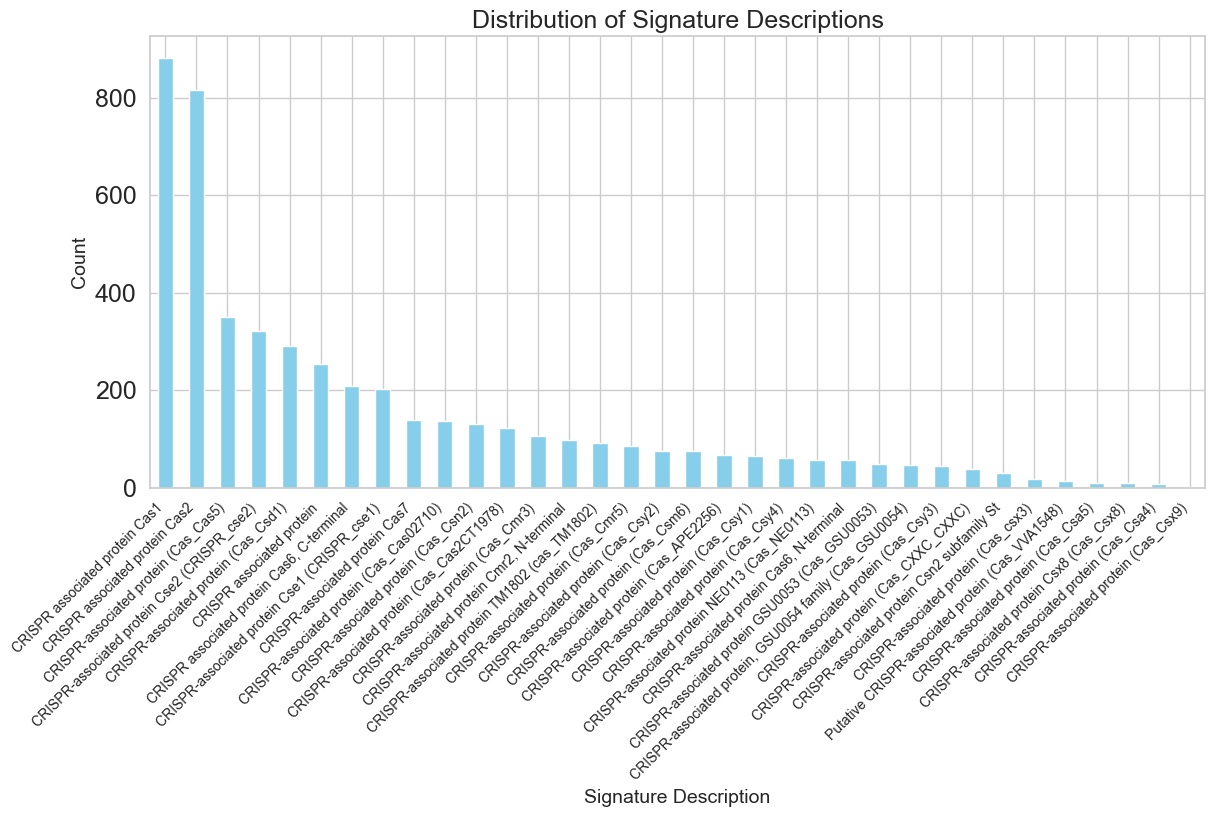

In [54]:
#distribut of each type
import matplotlib.pyplot as plt
import pandas as pd

# Count the occurrences of each 'Signature description' and sort by count in descending order
signature_counts = cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].value_counts()

# Create a figure with a specified size
plt.figure(figsize=(12, 8))  # Adjust figure size for better clarity

# Plot a bar chart with the counts, sorted by frequency (from most to least)
signature_counts.plot(kind='bar', color='skyblue')

# Set title and axis labels
plt.title('Distribution of Signature Descriptions', fontsize=18)
plt.xlabel('Signature Description', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels to avoid overlapping and adjust the font size
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout to prevent label overlap and improve spacing
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Signature description', y='Log10 Length',
C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:35: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Signature description', y='Log10 Length',
C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Signature description', y='Log10 Length',
C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:45: FutureWarning: 

The `scale` parameter has been

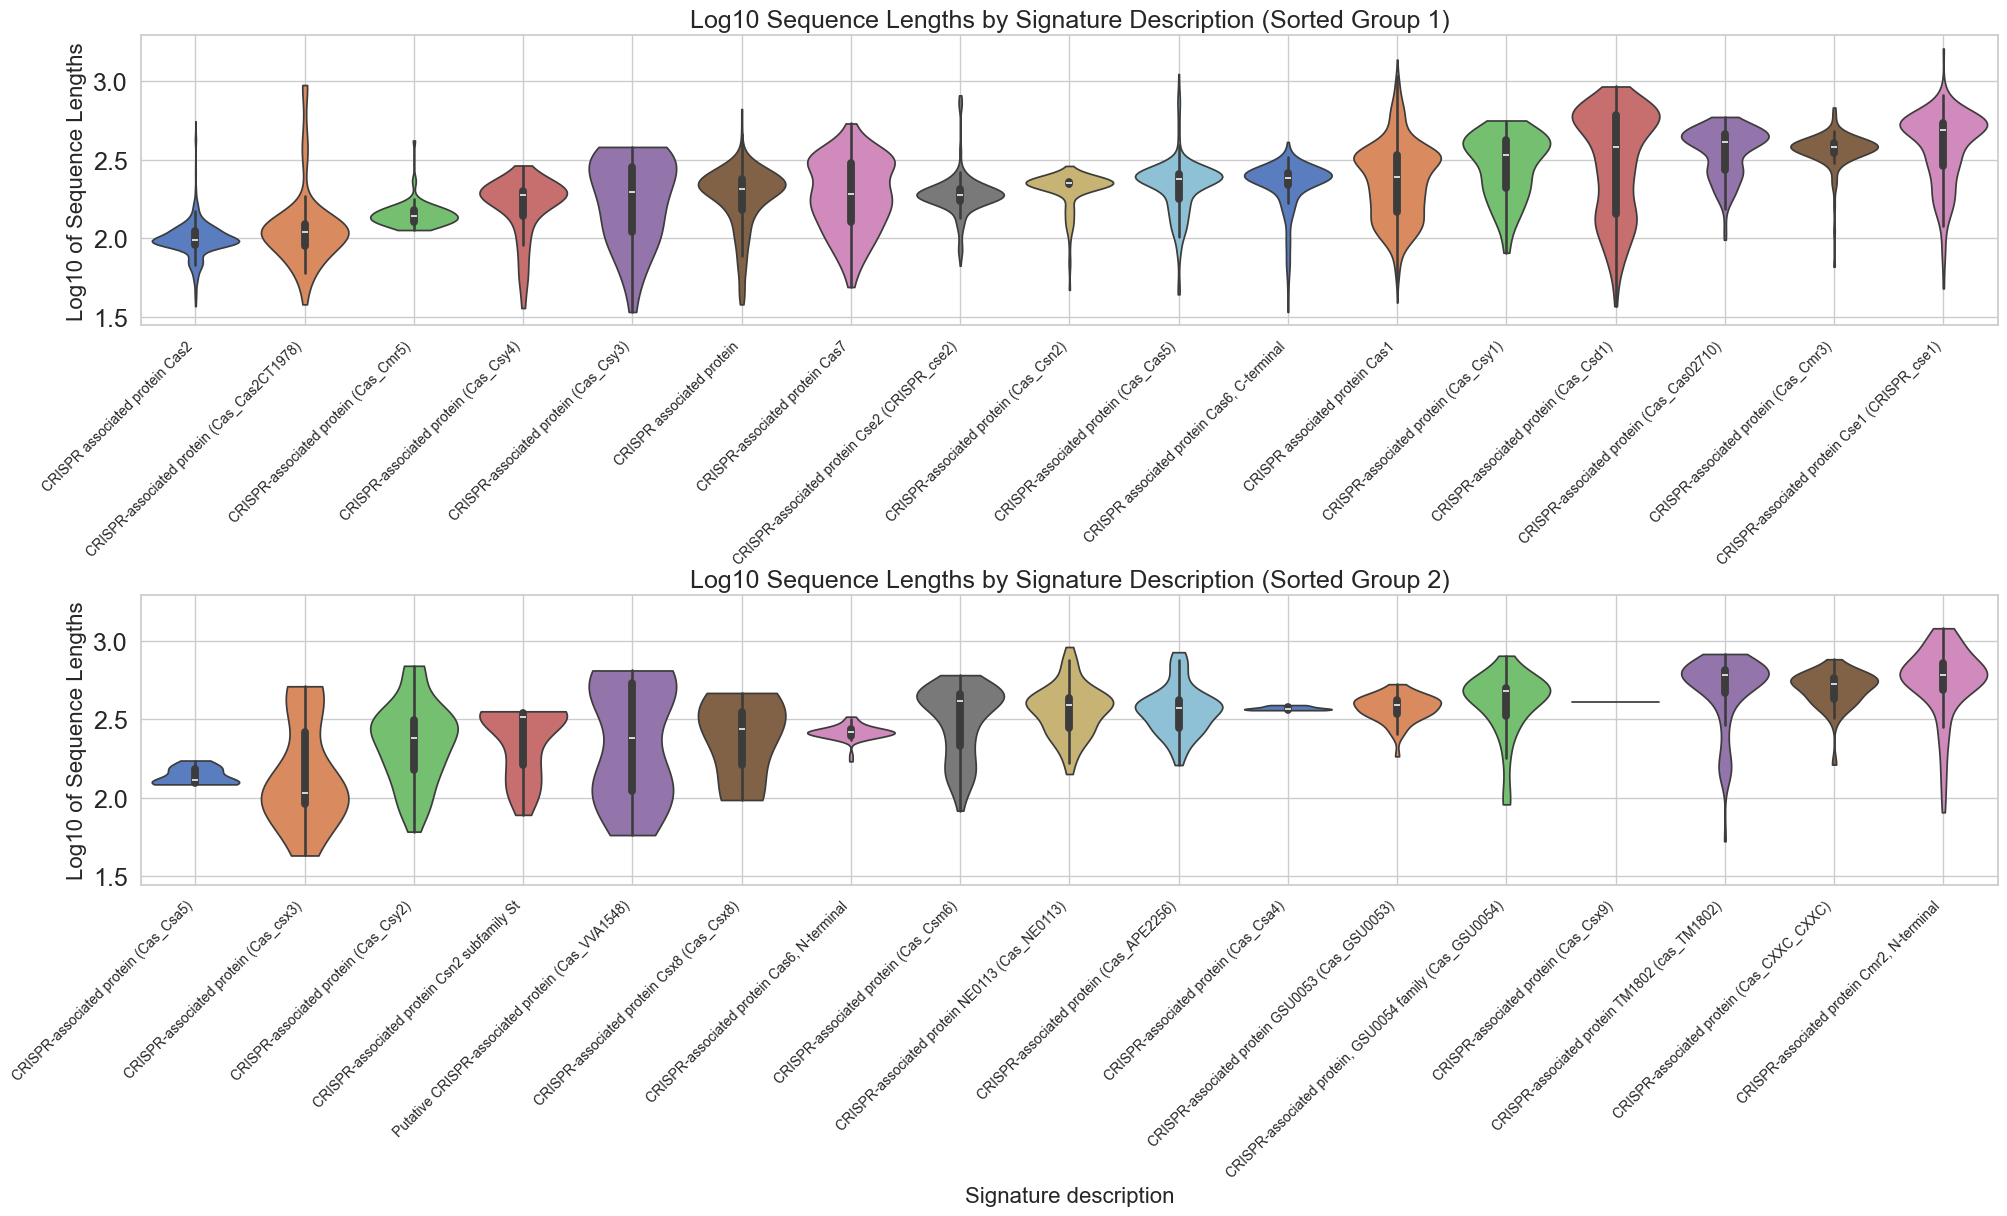

In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the log10 of sequence lengths
cas_associated_proteins_umap_embedding_non_duplicated_df['Log10 Length'] = np.log10(cas_associated_proteins_umap_embedding_non_duplicated_df['Length'])

# Get unique labels for splitting
unique_labels = cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].unique()

# Split the unique labels into two groups (roughly 50/50)
split_index = len(unique_labels) // 2
labels_group1 = unique_labels[:split_index]
labels_group2 = unique_labels[split_index:]

# Calculate the mean Log10 Length for each 'Signature description' in group 1 and group 2
mean_lengths_group1 = cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(labels_group1)].groupby('Signature description')['Log10 Length'].mean().sort_values()
mean_lengths_group2 = cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(labels_group2)].groupby('Signature description')['Log10 Length'].mean().sort_values()

# Sort the labels based on the mean Log10 Length for each group
sorted_labels_group1 = mean_lengths_group1.index
sorted_labels_group2 = mean_lengths_group2.index

# To align the x-ticks, we need the same number of x-ticks in both subplots
# Pad the shorter group with empty strings for alignment
max_len = max(len(sorted_labels_group1), len(sorted_labels_group2))
padded_labels_group1 = list(sorted_labels_group1) + [''] * (max_len - len(sorted_labels_group1))
padded_labels_group2 = list(sorted_labels_group2) + [''] * (max_len - len(sorted_labels_group2))

# Create a figure with two subplots and increase the size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharey=True)  # Share y-axis to keep the same scale

# Plot for the first group of labels (sorted by mean log10 length)
sns.violinplot(x='Signature description', y='Log10 Length', 
               data=cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(sorted_labels_group1)],
               ax=ax1, inner="box", palette="muted", scale="width", cut=0, order=sorted_labels_group1)  # Violin plot for distribution
ax1.set_title('Log10 Sequence Lengths by Signature Description (Sorted Group 1)')
ax1.set_xlabel('')
ax1.set_ylabel('Log10 of Sequence Lengths')
ax1.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels only for Group 1
ax1.grid(True)

# Plot for the second group of labels (sorted by mean log10 length)
sns.violinplot(x='Signature description', y='Log10 Length', 
               data=cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(sorted_labels_group2)],
               ax=ax2, inner="box", palette="muted", scale="width", cut=0, order=sorted_labels_group2)  # Violin plot for distribution
ax2.set_title('Log10 Sequence Lengths by Signature Description (Sorted Group 2)')
ax2.set_xlabel('Signature description')
ax2.set_ylabel('Log10 of Sequence Lengths')
ax2.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels only for Group 2
ax2.grid(True)

# Align the x-axis ticks for both subplots using the padded labels
ax1.set_xticks(np.arange(max_len))
ax1.set_xticklabels(padded_labels_group1, rotation=45, ha="right")

ax2.set_xticks(np.arange(max_len))
ax2.set_xticklabels(padded_labels_group2, rotation=45, ha="right")

# Adjust layout for better spacing and alignment
plt.tight_layout()

# Show the plots
plt.show()


Pair-wise distance

C:\Users\13330\AppData\Local\Temp\ipykernel_820\516765085.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)],
C:\Users\13330\AppData\Local\Temp\ipykernel_820\516765085.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)],


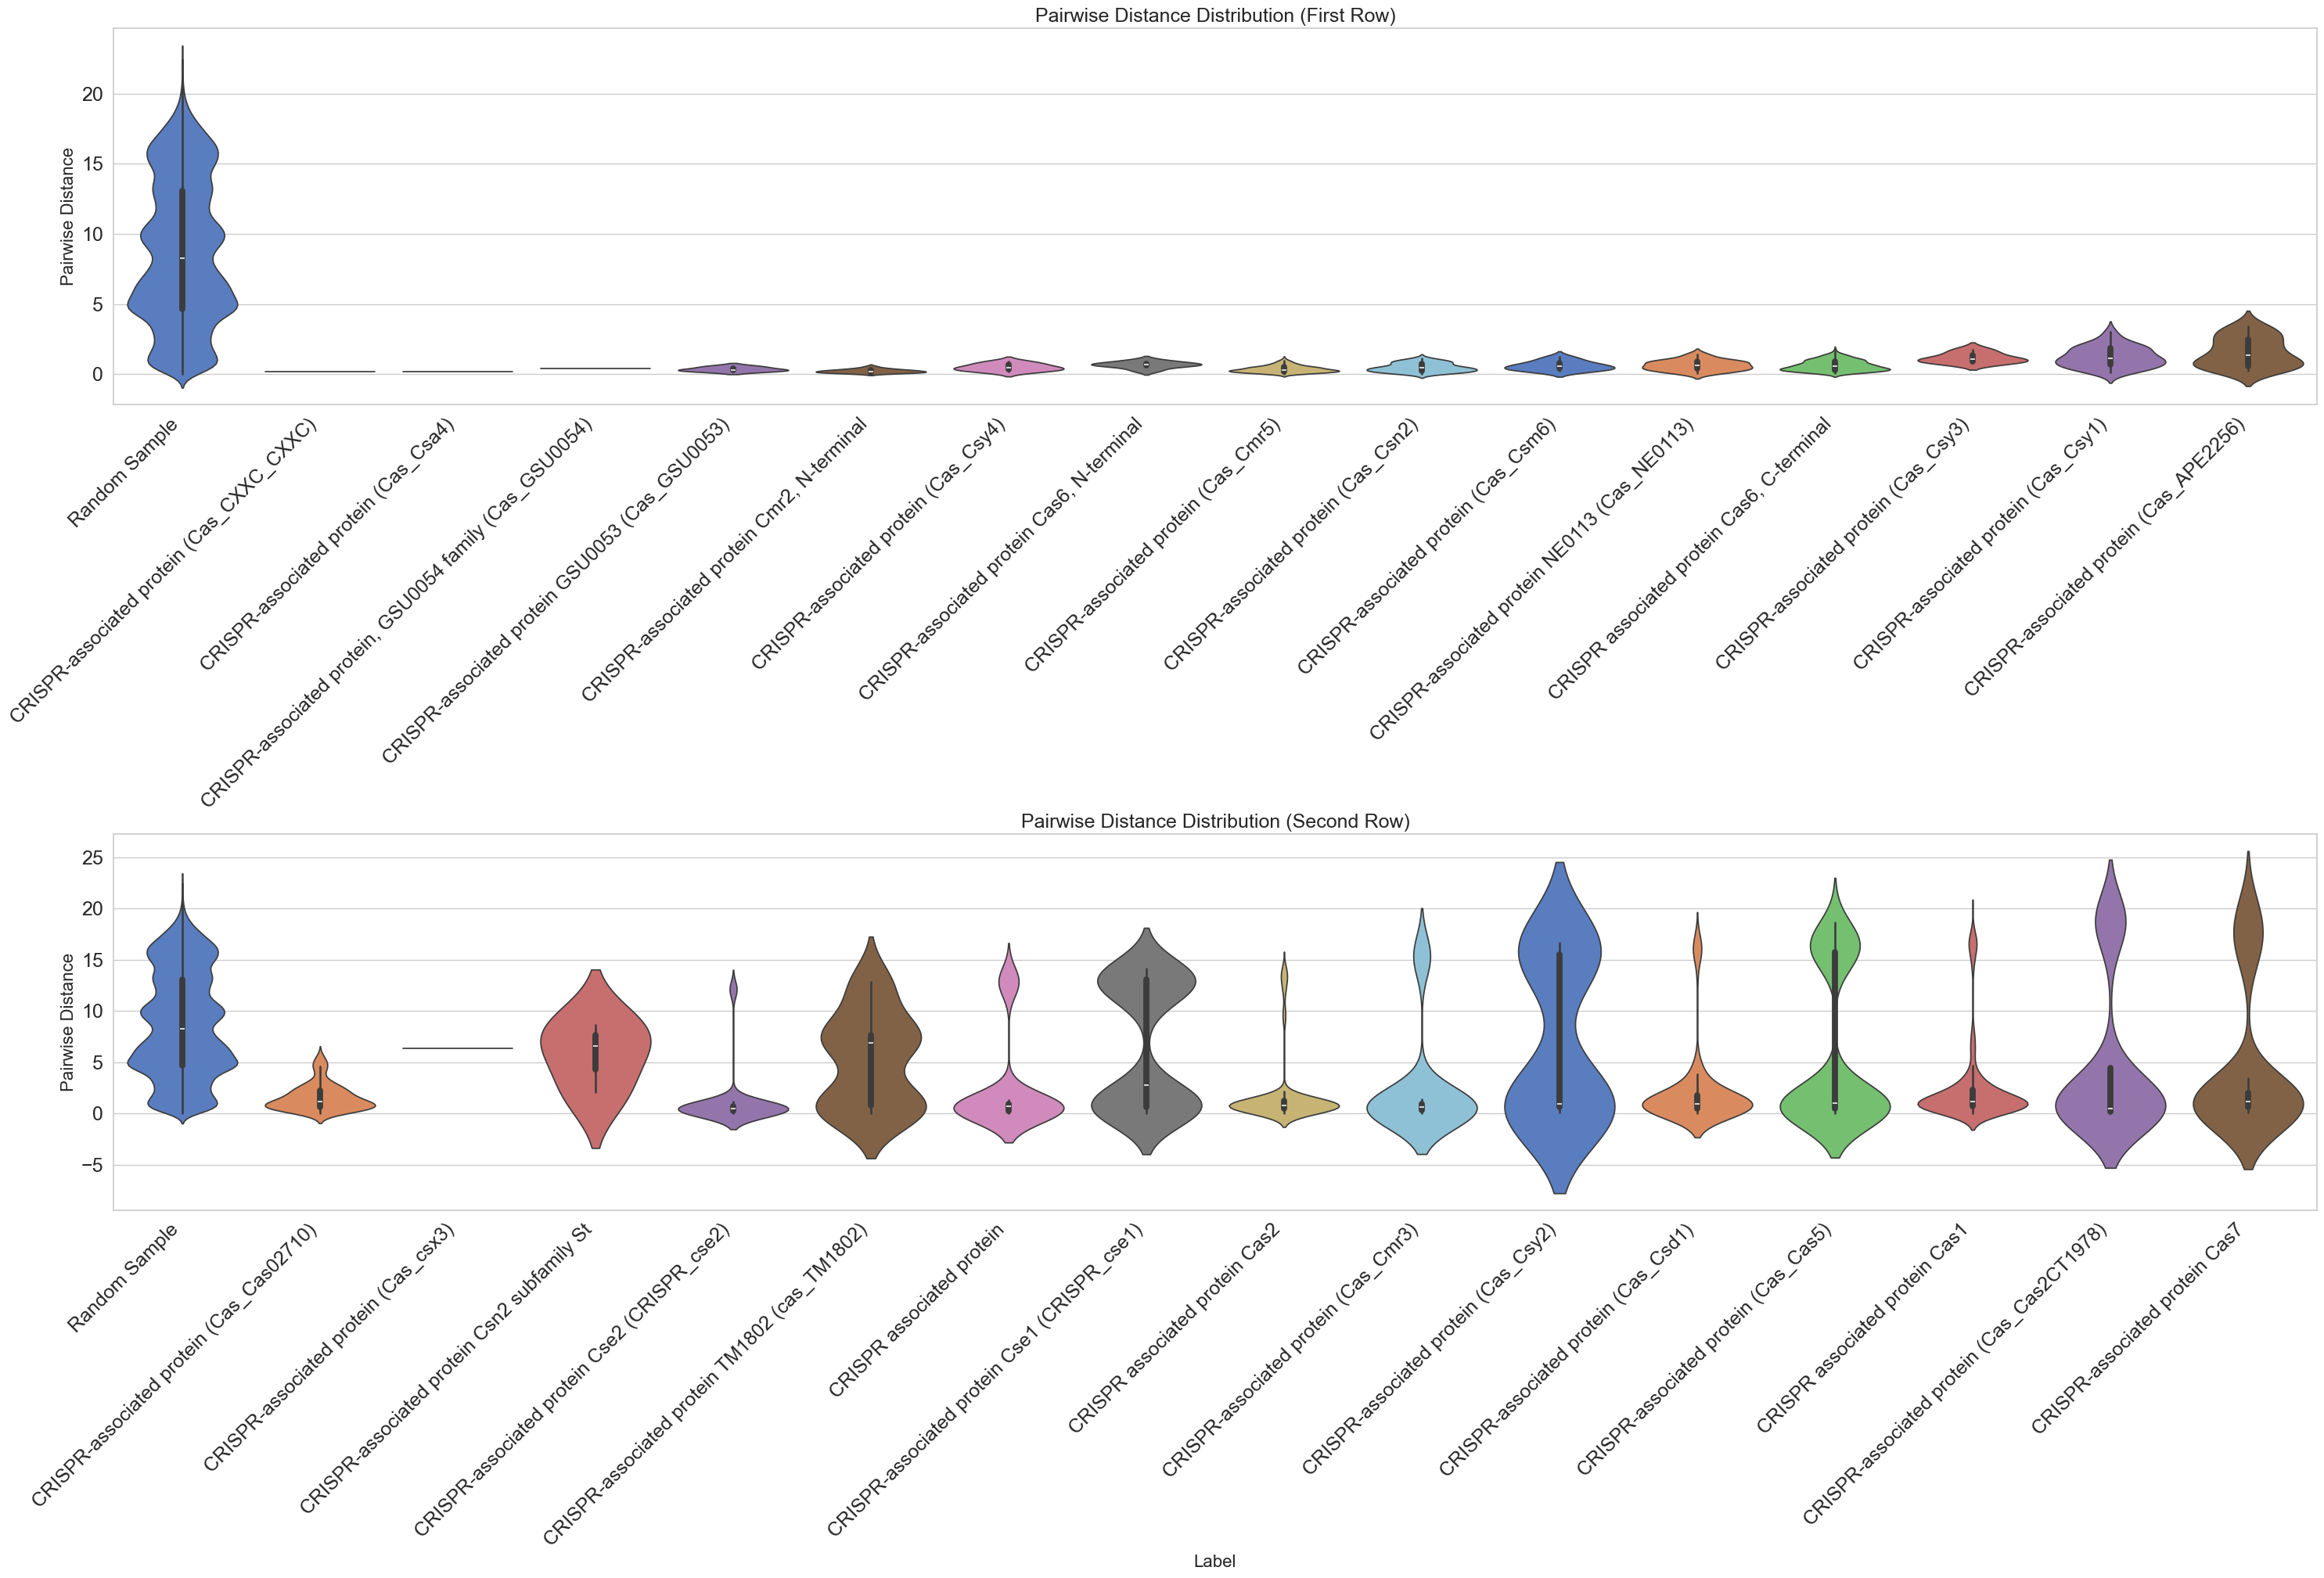

In [50]:
from scipy.spatial.distance import pdist, squareform
# Function to calculate pairwise distances
def calculate_pair_wise_distance(group):
    """
    Args:
    - group: DataFrame containing 'x', 'y' columns
    
    Returns:
    - distance_matrix: Squareform matrix of pairwise distances
    """
    embeddings = group[['x', 'y']].values
    pairwise_distances = pdist(embeddings, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    return distance_matrix
import matplotlib.pyplot as plt

# 设置全局字体大小
plt.rcParams['font.size'] = 20  # 全局默认字体大小
plt.rcParams['axes.titlesize'] = 18  # 子图标题字体大小
plt.rcParams['axes.labelsize'] = 16  # x轴和y轴标签字体大小
plt.rcParams['xtick.labelsize'] = 18  # x轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 18  # y轴刻度字体大小

# Randomly sample 500 points from the dataset
sampled_data = cas_associated_proteins_umap_embedding_non_duplicated_df.sample(n=500, random_state=42)

# Calculate pairwise distances for the random sample
distance_matrix = calculate_pair_wise_distance(sampled_data)

# Extract the upper triangular matrix (excluding the diagonal)
upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]

# Store the distance values in a DataFrame with a 'Random Sample' label
baseline_data = pd.DataFrame({'Distance': upper_triangle_values, 'Label': 'Random Sample'})

# Group by label and calculate pairwise distances for each group
grouped = sampled_data.groupby('Signature description')

# Collect all upper triangle distance values and add a label for each group
data = []
max_ranges = {}
plt.rcParams['font.size'] = 1
for label, group in grouped:
    distance_matrix = calculate_pair_wise_distance(group)
    # Extract the upper triangular matrix (excluding the diagonal)
    upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    if len(upper_triangle_values) > 0:  # Ensure the data is not empty
        data.append(pd.DataFrame({'Distance': upper_triangle_values, 'Label': label}))
        max_ranges[label] = upper_triangle_values.max()

# Combine all data into a single DataFrame
plot_data = pd.concat(data)

# Add the random sample data to the plot data
plot_data = pd.concat([baseline_data, plot_data])

# Sort labels by maximum distance value
sorted_labels = sorted(max_ranges.keys(), key=lambda x: max_ranges[x])

# Split sorted labels into two groups and add 'Random Sample' at the beginning of each
labels_group_1 = ['Random Sample'] + sorted_labels[:len(sorted_labels)//2]
labels_group_2 = ['Random Sample'] + sorted_labels[len(sorted_labels)//2:]

# Create the plot with two rows
fig, axes = plt.subplots(2, 1, figsize=(30, 20))  # Increased figure size for better spacing

# First row: Plot the first group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)], 
               order=labels_group_1, inner="box", palette="muted", ax=axes[0])
axes[0].set_title("Pairwise Distance Distribution (First Row)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Pairwise Distance")
axes[0].set_xticks(np.arange(len(labels_group_1)))  # Ensure correct number of ticks
axes[0].set_xticklabels(labels_group_1, rotation=45, ha='right')  # Correct rotation and alignment

# Second row: Plot the second group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)], 
               order=labels_group_2, inner="box", palette="muted", ax=axes[1])
axes[1].set_title("Pairwise Distance Distribution (Second Row)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Pairwise Distance")
axes[1].set_xticks(np.arange(len(labels_group_2)))  # Ensure correct number of ticks
axes[1].set_xticklabels(labels_group_2, rotation=45, ha='right')  # Correct rotation and alignment

# Adjust layout
plt.tight_layout()
plt.show()


Found in single labels the number of labels that are larger than threshold is less than all labels, indicating some labels are in seqs with multiple labels.

calculate within pair wise distance and plot only in Cas1 & Cas2


# Task3 Semi-supervised Learning for unlabelled data!

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import scanpy as sc



# Prepare for data

In [5]:
import os
import glob
import pandas as pd
from Core.Utils.utils import  load_esm_embedding
#all protein accession
def create_protein_accession_df():
    """
    create a dataframe with all protein accession
    """
    _, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding
#create df
    esm_all_df = pd.DataFrame({
                            'Protein accession': esm_embedding_accession,
                            })
    esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)
    return esm_all_df

total_interpro_df = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')
#load esm embedding and labels
esm_embedding, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding


#create df
esm_all_df = pd.DataFrame({
                        'Protein accession': esm_embedding_accession,
                        'esm_embedding':esm_embedding})
esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)



folder = work_path.environment_path  # The project folder of cluster of local
embedding_folder = 'Shenzhen_GLM_Project/Output'
data_folder = 'Shenzhen_GLM_Project/Data'

# Use glob to recursively find the file in the Output directory
umap_embedding_euc_df = pd.read_csv(glob.glob(os.path.join(folder, embedding_folder, '**', 'esm_3_umap_all_embedding_euclidean_top_10_pfam.csv'), recursive=True)[0])
umap_embedding_cos_df = pd.read_csv(glob.glob(os.path.join(folder, embedding_folder, '**', 'esm_3_umap_all_embedding_cosine_top_10_pfam.csv'), recursive=True)[0])
total_interpro_pfam_df = pd.read_csv(glob.glob(os.path.join(folder, data_folder, '**', 'total_interpro_pfam.csv'),recursive=True)[0])
protein_accession_df = create_protein_accession_df()


This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Label\total_fasta_interpro.tsv
This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Preparation_Data\total_esm3_normalized_embedding.pkl
This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Preparation_Data\total_esm3_normalized_embedding.pkl


In [6]:
umap_embedding_euc_df['Protein accession'] = protein_accession_df['Protein accession']
#merge umap_embedding_euc_df and total_interpro_pfam_df, if multiple label exists, then keep multiple embeddings
total_interpro_pfam_df_filtered = total_interpro_pfam_df[['Protein accession', 'Signature description']]
umap_embedding_euc_all_pfam_df = pd.merge(umap_embedding_euc_df, total_interpro_pfam_df_filtered, on='Protein accession', how='left')

#separate non-labeled and labeled data
umap_embedding_euc_all_pfam_labeld_df = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['Signature description'].notna()]
umap_embedding_euc_all_pfam_non_labeld_df = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['Signature description'].isna()]


## Subtask3.1 Basic KNN for labeling data


# KNN Workflow

1. **Fit KNN Model**: 
   - Use `umap_embedding_all_pfam_df` (141297 entries) to fit the KNN model.

2. **Find Neighbors**:
   - For each label in `umap_embedding_all_pfam_df`, find nearest neighbors in `umap_embedding_all_pfam_df`.

3. **Assign Labels**:
   - Label the nearest neighbors in `umap_embedding_euc_all_pfam_non_labeld_df`.
   - a labeld data could have multiple labels, record each for non-labeled data

4. **Update Dataset**:
   - Merge labeled data into `umap_embedding_euc_all_df` to get the final labeled dataset.


plot of distributions of seqs with multiple annotations

In [7]:
def filter_pfam_df(umap_embedding_pfam_df,threshold=50):
    """
    Only keep pfam annotations occure more than threshold
    """
    umap_embedding_pfam_df_copy = umap_embedding_pfam_df.copy()
    pfam_counts = umap_embedding_euc_all_pfam_df['Signature description'].value_counts()
    pfam_mapping = {val: (np.nan if count < threshold else val) for val, count in pfam_counts.items()}
    umap_embedding_pfam_df_copy['Signature description'] = umap_embedding_pfam_df_copy['Signature description'].map(pfam_mapping)
    return umap_embedding_pfam_df_copy

#define a KNN based search
class KNNPropgation(NearestNeighbors):
    def __init__(self, n_neighbors=5, **kwargs):
        super().__init__(n_neighbors=n_neighbors, **kwargs)

    def nearest_indices(self, X):
        return self.kneighbors(X, return_distance=False)
    
    def nearest_distance(self, X):
        return self.kneighbors(X, return_distance=True)[0]


Give new columns of if they have multiple labels

C:\Users\13330\AppData\Local\Temp\ipykernel_40748\3830661753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_proteins['annotation_count'] = unique_proteins['Protein accession'].map(annotation_counts)
C:\Users\13330\AppData\Local\Temp\ipykernel_40748\3830661753.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')


Total number of proteins with multiple different annotations: 5563
Total number of unique proteins: 128012


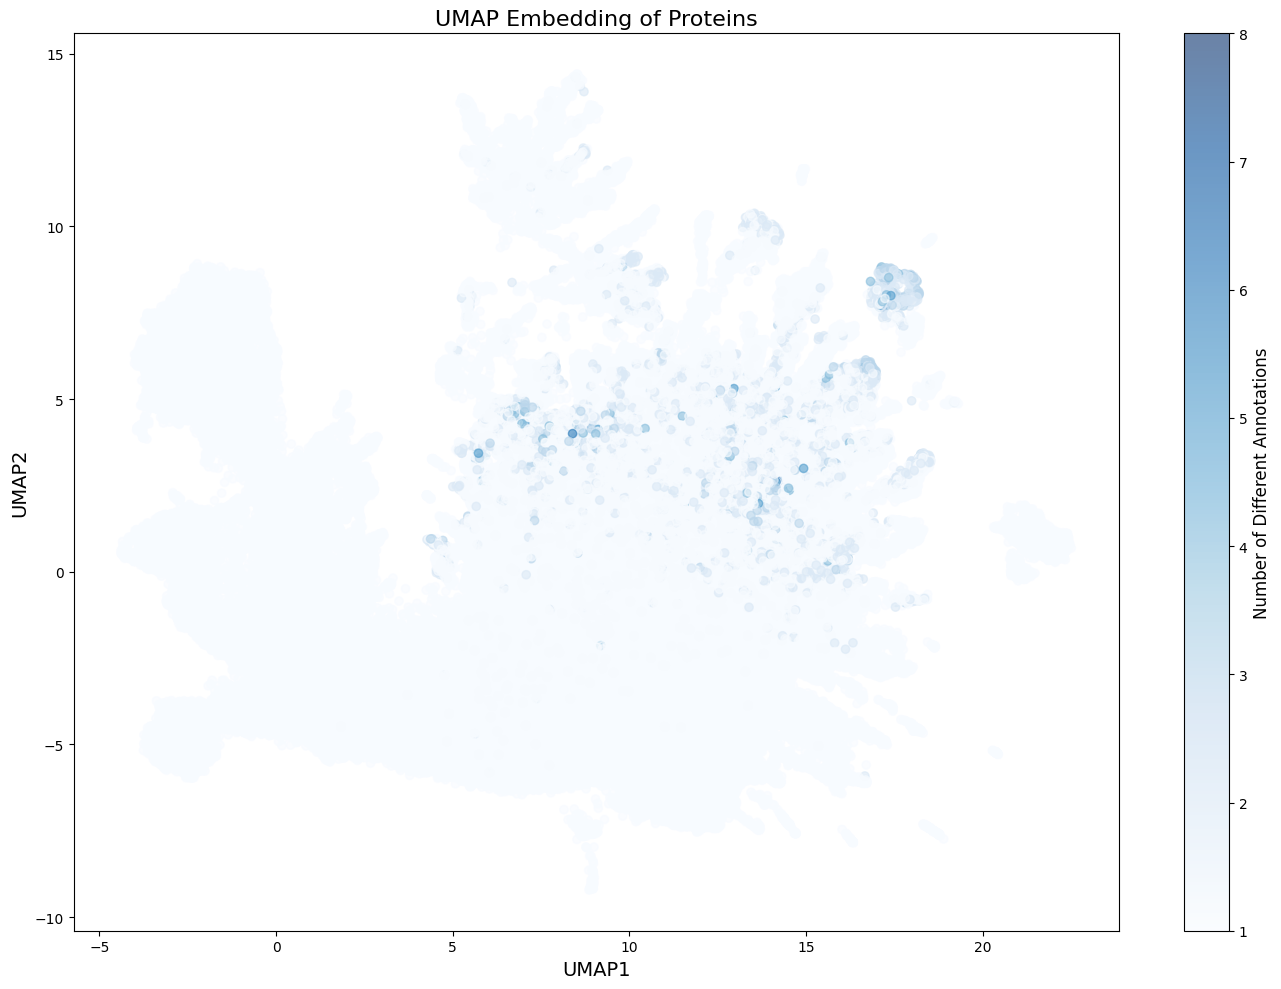


Sample of proteins with multiple different annotations:

Protein: EMBL_ERZ808056&&contig_1173&&899_7382_1
Number of different annotations: 8
Annotations: FIVAR domain, Glycosyl hydrolases family 2, sugar binding domain, NPCBM/NEW2 domain, Glycosyl hydrolases family 2, TIM barrel domain, F5/8 type C domain, Glycosyl hydrolases family 2, Glycoside hydrolase family 2 C-terminal domain 5, Cadherin-like beta sandwich domain

Protein: GCF_900169665.1&&NZ_LT835157&&78158_88058_1
Number of different annotations: 8
Annotations: Glycosyl hydrolase 31 N-terminal galactose mutarotase-like domain, Carbohydrate binding module (family 35), Glycosyl hydrolase family 31 C-terminal domain, FIVAR domain, Glycosyl hydrolases family 31 TIM-barrel domain, Carbohydrate binding module (family 6), Bacterial alpha-L-rhamnosidase 6 hairpin glycosidase domain, Domain of unknown function (DUF5110)

Protein: EMBL_ERZ1023351&&contig_141&&3620_12050_1
Number of different annotations: 7
Annotations: YadA head domain 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 计算每个蛋白质的不同注释数量
annotation_counts = umap_embedding_euc_all_pfam_df.groupby('Protein accession')['Signature description'].nunique()

# 创建一个新的DataFrame，只包含每个蛋白质的一行
unique_proteins = umap_embedding_euc_all_pfam_df.drop_duplicates(subset='Protein accession')

# 添加 'annotation_count' 列
unique_proteins['annotation_count'] = unique_proteins['Protein accession'].map(annotation_counts)

# 获取统计信息
multiple_proteins = unique_proteins[unique_proteins['annotation_count'] > 1]
print(f"Total number of proteins with multiple different annotations: {len(multiple_proteins)}")
print(f"Total number of unique proteins: {len(unique_proteins)}")

# 创建图形和轴
fig, ax = plt.subplots(figsize=(14, 10))

# 创建颜色映射
cmap = plt.cm.get_cmap('Blues')
max_count = unique_proteins['annotation_count'].max()

# 绘制散点图
scatter = ax.scatter(unique_proteins['x'], unique_proteins['y'], 
                     c=unique_proteins['annotation_count'], 
                     cmap=cmap, 
                     norm=plt.Normalize(vmin=1, vmax=max_count),
                     alpha=0.6)

ax.set_title('UMAP Embedding of Proteins', fontsize=16)
ax.set_xlabel('UMAP1', fontsize=14)
ax.set_ylabel('UMAP2', fontsize=14)

# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Number of Different Annotations', fontsize=12)

plt.tight_layout()
plt.show()

# 显示具有多个不同注释的蛋白质的样本
print("\nSample of proteins with multiple different annotations:")
sample_proteins = multiple_proteins.nlargest(5, 'annotation_count')
for _, protein in sample_proteins.iterrows():
    print(f"\nProtein: {protein['Protein accession']}")
    print(f"Number of different annotations: {protein['annotation_count']}")
    annotations = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['Protein accession'] == protein['Protein accession']]['Signature description'].unique()
    print("Annotations:", ", ".join(annotations))

### Co-occurrence analysis

give each preotien accession a label of if multiple labels


In [17]:
annotation_counts = umap_embedding_euc_all_pfam_df.groupby('Protein accession')['Signature description'].nunique()

# 创建一个新的列 'if_multiple_labels'
umap_embedding_euc_all_pfam_df['if_multiple_labels'] = umap_embedding_euc_all_pfam_df['Protein accession'].map(annotation_counts > 1).astype(int)
#add a new column of protein index id
protein_ids, _ = pd.factorize(umap_embedding_euc_all_pfam_df['Protein accession'])
umap_embedding_euc_all_pfam_df['protein_id'] = protein_ids

#only keep per seq with unique different labels
umap_embedding_euc_all_pfam_no_duplicated_df = umap_embedding_euc_all_pfam_df.drop_duplicates(subset=['Protein accession','Signature description']).reset_index(drop=True)



先提取出X,Y of each seq, fit, 然后每个protein 有一个id, grouped by id, 然后查询对应的Signature description, 计算组合!

In [9]:
#prepare all embedding data
umap_embedding_euc_array = umap_embedding_euc_df.loc[:,['x','y']].to_numpy()

#set new KNN and fit all data
k = 14 # k needs to be added 1
KNN_serach = KNNPropgation(k)
#fit KNN
KNN_serach.fit(umap_embedding_euc_array)

KNNPropgation(n_neighbors=14)

In [18]:
#First find target seqs (with multiple pfam labels)
umap_embedding_multple_labels_id = umap_embedding_euc_all_pfam_no_duplicated_df[umap_embedding_euc_all_pfam_no_duplicated_df['if_multiple_labels'] == 1].protein_id.unique()
umap_embedding_euc_multi_pfam_array = umap_embedding_euc_array[umap_embedding_multple_labels_id,:]

#find nearest indices
KNN_nearest_ids = KNN_serach.nearest_indices(umap_embedding_euc_multi_pfam_array) #drop the point itself

umap_multi_self_id, umap_muliti_nearest_id = KNN_nearest_ids[:,0],KNN_nearest_ids[:,1:]
tem_id, tem_own_id = umap_muliti_nearest_id[0:,], umap_multi_self_id[0:,]


In [57]:

#first find nearst & self points' info
umap_nearest_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id'].isin(tem_id)]
umap_self_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id']== tem_own_id]

#then ignore points without label or single labels
umap_nearest_filtered_info = umap_nearest_info[umap_nearest_info['if_multiple_labels']==1]

#get self and nearst labels
umap_nearest_labels = list(umap_nearest_filtered_info.loc[:,'Signature description'].values)
umap_self_labels = list(umap_self_info.loc[:,'Signature description'].values)



- For all labels count combinations
- Only count combinations of self point and its nearest points

In [72]:
import os
from itertools import product

# Function to compute label combinations
def combination_count(nearest_id, own_id, strategy='product'):
    """
    Give nearest ids and own id, count combinations.
    strategy: calculate combinations of all labels or just product with neighbor labels
    """
    assert strategy in ['combination', 'product'], 'Strategy should be "all" or "self"!'
    nearest_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id'].isin(nearest_id)]
    self_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id'] == own_id]
    nearest_filtered_info = nearest_info[nearest_info['if_multiple_labels'] == 1] #only consider seqs with multiple labels
    nearest_labels = list(nearest_filtered_info['Signature description'].values)
    self_labels = list(self_info['Signature description'].values)
    combination_labels = product(self_labels,nearest_labels)
    return combination_labels

# Function to write combinations to a text file in append mode
def write_combinations(combination_labels, filename='product_all_0.txt', save_path=None):
    # Create the full path if save_path is provided
    if save_path:
        # Ensure the save_path exists, create it if necessary
        os.makedirs(save_path, exist_ok=True)
        path = os.path.join(save_path, filename)
    else:
        path = filename
    
    # Check if the file exists and is empty (to avoid adding headers multiple times)
    write_header = not os.path.exists(path) or os.path.getsize(path) == 0

    # Open the text file in append mode ('a')
    with open(path, mode='a') as file:  # 'a' means append mode
        # Write the header only if the file is new or empty
        if write_header:
            file.write('Label1 \t Label2\n')  # Write header only once
        
        # Iterate through each combination and write to the file
        for comb in combination_labels:
            # Join the combination as a string and write it to the file
            file.write('\t'.join(comb) + '\n')

# Function to handle the combination process and writing for each sample
def process_sample(nearest_id, own_id, filename='product_all_0.txt', save_path=None):
    # Compute combinations
    combinations_labels = combination_count(nearest_id, own_id)
    # Write combinations to file (in append mode)
    write_combinations(combinations_labels, filename, save_path)

# Apply process_sample to each sample using map
def process_all_samples(nearest_ids_array, own_ids, filename='product_all_0.txt', save_path=None):
    # Use map to apply process_sample to all samples
    list(map(lambda nearest_ids, own_id: process_sample(nearest_ids, own_id, filename, save_path),
             nearest_ids_array, own_ids))

# Example usage
# Corrected usage: ensure filename is the third argument and the path is the fourth


process_all_samples(tem_id, tem_own_id, 'product_all_0.txt', '../../Output/ESM/Embedding_analysis/')


In [26]:
import collections
import pandas as pd

def count_combinations_to_df(file_path):
    # Initialize a Counter to store combination counts
    combination_counter = collections.Counter()

    # Open the file and process each line
    with open(file_path, 'r') as file:
        # Skip the header
        next(file)

        for line in file:
            # Split the line into two labels
            label1, label2 = line.strip().split('\t')

            # Sort the labels so that A-B and B-A are treated the same
            sorted_comb = tuple(sorted([label1, label2]))

            # Increment the counter for this combination
            combination_counter[sorted_comb] += 1

    # Convert the Counter data to a list of dictionaries for the DataFrame
    data = [{'Label1': comb[0], 'Label2': comb[1], 'Count': count} for comb, count in combination_counter.items()]
    
    # Create a DataFrame
    df = pd.DataFrame(data)

    return df




# Example usage
file_path = '../../Output/ESM/Embedding_analysis/product_all_0.txt'  # Replace with your actual file path
co_occur_df = count_combinations_to_df(file_path)
co_occur_df.columns = ['Label1','Label2','Count']

def pfam_occurrence_counts(pfam_1,pfam_2):
    pfam_1_counts = len(umap_embedding_euc_all_pfam_no_duplicated_df[
        (umap_embedding_euc_all_pfam_no_duplicated_df['Signature description'] == pfam_1) & 
        (umap_embedding_euc_all_pfam_no_duplicated_df['if_multiple_labels'] == 1)
    ])
    
    pfam_2_counts = len(umap_embedding_euc_all_pfam_no_duplicated_df[
        (umap_embedding_euc_all_pfam_no_duplicated_df['Signature description'] == pfam_2) & 
        (umap_embedding_euc_all_pfam_no_duplicated_df['if_multiple_labels'] == 1)])

    return (pfam_1_counts,pfam_2_counts)




In [ ]:

#normalize co-occurrence
def calculate_normalization_factor(pfam_count_1, pfam_count_2):
    return np.sqrt(pfam_count_1 * pfam_count_2)

def co_occur_normalized_df(co_occurrence_df, reference_df):
    # 创建一个新的 DataFrame 来存储归一化后的结果
    normalized_df = co_occurrence_df.copy()
    
    # 只考虑 if_multiple_labels 为 1 的行
    multiple_labels_df = reference_df[reference_df['if_multiple_labels'] == 1]
    
    # 预先计算所有 pfam 的出现次数（只在多标签蛋白质中）
    pfam_counts = multiple_labels_df['Signature description'].value_counts()
    
    def process_row(row):
        pfam_1 = row['Label1']
        pfam_2 = row['Label2']
        
        # 查表获取每个 pfam 的出现次数
        pfam_1_count = pfam_counts.get(pfam_1, 0)
        pfam_2_count = pfam_counts.get(pfam_2, 0)
        
        # 计算归一化因子
        factor = calculate_normalization_factor(pfam_1_count, pfam_2_count)
        
        # 计算归一化后的计数
        normalized_count = row['Count'] / factor if factor != 0 else 0
        
        return pd.Series({
            'Label1_Count': pfam_1_count,
            'Label2_Count': pfam_2_count,
            'Normalization_Factor': factor,
            'Count_normalized': normalized_count
        })
    
    # 应用处理函数到每一行
    result = normalized_df.apply(process_row, axis=1)
    
    # 将结果合并到原始 DataFrame
    normalized_df = pd.concat([normalized_df, result], axis=1)
    
    return normalized_df

# 使用函数
normalized_co_occur_df = co_occur_normalized_df(co_occur_df, umap_embedding_euc_all_pfam_no_duplicated_df)


In [48]:
#set a threshold to filter out co-occurrence too low
threshold = 30
filtered_df = normalized_co_occur_df[(normalized_co_occur_df['Label1'] != normalized_co_occur_df['Label2']) & 
                                     (normalized_co_occur_df['Count'] >= threshold)]
#drop self connection
filtered_df.to_csv('../../Output/ESM/Embedding_analysis/co_occurrence_Ochiai_normalized_0.txt',sep='\t')

In [60]:
filtered_df.Count_normalized.quantile(0.75)

3.551081494504336

In [341]:
import pandas as pd

# 计算每个蛋白质的不同注释数量
annotation_counts = umap_embedding_euc_all_pfam_df.groupby('Protein accession')['Signature description'].nunique()

# 创建一个新的列 'if_multiple_labels'
umap_embedding_euc_all_pfam_df['if_multiple_labels'] = umap_embedding_euc_all_pfam_df['Protein accession'].map(annotation_counts > 1).astype(int)

# 显示结果的前几行
print(umap_embedding_euc_all_pfam_df[['Protein accession', 'Signature description', 'if_multiple_labels']].head(10))

# 统计信息
total_proteins = umap_embedding_euc_all_pfam_df['Protein accession'].nunique()
multiple_label_proteins = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['if_multiple_labels'] == 1]['Protein accession'].nunique()

print(f"\nTotal number of unique proteins: {total_proteins}")
print(f"Number of proteins with multiple labels: {multiple_label_proteins}")
print(f"Percentage of proteins with multiple labels: {multiple_label_proteins/total_proteins:.2%}")

                            Protein accession  \
0             2800531478 hypothetical protein   
1    EMBL_ERZ1022727&&contig_36&&3605_4121_-1   
2    EMBL_ERZ1022742&&contig_2860&&482_1856_1   
3      EMBL_ERZ1022753&&contig_3010&&33_588_1   
4  EMBL_ERZ1022756&&contig_46&&29777_30431_-1   
5   EMBL_ERZ1022756&&contig_717&&7596_7962_-1   
6    EMBL_ERZ1022758&&contig_121&&1720_2167_1   
7    EMBL_ERZ1022763&&contig_333&&745_1993_-1   
8    EMBL_ERZ1022779&&contig_554&&128_3227_-1   
9    EMBL_ERZ1022808&&contig_810&&163_1435_-1   

                       Signature description  if_multiple_labels  
0                                        NaN                   0  
1                                        NaN                   0  
2                                        NaN                   0  
3                                        NaN                   0  
4                                        NaN                   0  
5                                        NaN              

## Subtask 3.2 PAGA of embedding  

In [8]:
esm_all_pfam_embedding_df = pd.merge(esm_all_df, total_interpro_pfam_df, on='Protein accession', how='left') # merge df with embedding and annotations
esm_all_pfam_embedding_df['Signature description'] = esm_all_pfam_embedding_df['Signature description'].fillna('No')# fill seqs without annotations
remained_columns = ['Protein accession','Signature description', 'esm_embedding']
esm_all_pfam_embedding_df = esm_all_pfam_embedding_df.loc[:,remained_columns]
#prepare for adata format
esm_all_pfam_embedding = np.array([np.array(embedding) for embedding in esm_all_pfam_embedding_df['esm_embedding'].values])


In [188]:
import matplotlib.pyplot as plt
import numpy as np

# 获取标签计数，排除"No"
label_counts = esm_all_pfam_embedding_df.loc[:,'Signature description'].value_counts()
label_counts = label_counts[label_counts.index != 'No']
count_distribution = label_counts.value_counts().sort_index()


# 添加一些可能的阈值线作为参考
thresholds = [1,10, 30,50, 100]

plt.tight_layout()
plt.show()

# 打印一些统计信息
print(f"Total number of unique signatures: {len(label_counts)}")
print(f"Number of signatures that appear only once: {count_distribution.get(1, 0)}")
print(f"Number of signatures that appear 10 times or more: {sum(count_distribution[count_distribution.index >= 10])}")
print(f"Number of signatures that appear 30 times or more: {sum(count_distribution[count_distribution.index >= 30])}")
print(f"Number of signatures that appear 50 times or more: {sum(count_distribution[count_distribution.index >= 50])}")
print(f"Number of signatures that appear 300 times or more: {sum(count_distribution[count_distribution.index >= 250])}")

# 计算累积分布
cumulative_distribution = count_distribution.sort_index().cumsum()
total_signatures = cumulative_distribution.iloc[-1]

# 打印累积分布信息
print("\nCumulative distribution:")
print(f"Signatures that appear 1 time or more: {total_signatures} (100%)")
print(f"Signatures that appear 10 times or more: {total_signatures - cumulative_distribution.get(9, 0)} ({(total_signatures - cumulative_distribution.get(9, 0)) / total_signatures:.2%})")
print(f"Signatures that appear 30 times or more: {total_signatures - cumulative_distribution.get(29, 0)} ({(total_signatures - cumulative_distribution.get(29, 0)) / total_signatures:.2%})")
print(f"Signatures that appear 50 times or more: {total_signatures - cumulative_distribution.get(49, 0)} ({(total_signatures - cumulative_distribution.get(49, 0)) / total_signatures:.2%})")
print(f"Signatures that appear 100 times or more: {total_signatures - cumulative_distribution.get(99, 0)} ({(total_signatures - cumulative_distribution.get(99, 0)) / total_signatures:.2%})")

<Figure size 640x480 with 0 Axes>

Total number of unique signatures: 5581
Number of signatures that appear only once: 2132
Number of signatures that appear 10 times or more: 845
Number of signatures that appear 30 times or more: 288
Number of signatures that appear 50 times or more: 170
Number of signatures that appear 300 times or more: 24

Cumulative distribution:
Signatures that appear 1 time or more: 5581 (100%)
Signatures that appear 10 times or more: 845 (15.14%)
Signatures that appear 30 times or more: 288 (5.16%)
Signatures that appear 50 times or more: 170 (3.05%)
Signatures that appear 100 times or more: 82 (1.47%)


- PAGA by Signature description directly
- PAGA by leiden group and assign signature description manually

In [17]:
#get adata for X
esm_all_pfam_embedding_adata = sc.AnnData(esm_all_pfam_embedding)
esm_all_pfam_embedding_adata.obs['Signature description'] = esm_all_pfam_embedding_df['Signature description'].values



In [19]:
#add obs


from matplotlib import use


#esm_all_pfam_embedding_adata.obs['Signature description'] = esm_all_pfam_embedding_df_filtered.values

esm_all_pfam_embedding_adata.X = esm_all_pfam_embedding_adata.X.astype("float64")
#run neighbors
sc.pp.neighbors(esm_all_pfam_embedding_adata, n_neighbors=15, n_pcs=2,use_rep='X')


In [ ]:
sc.tl.draw_graph(esm_all_pfam_embedding_adata)
sc.pl.draw_graph(esm_all_pfam_embedding_adata, color='Signature description')

In [32]:
#set a threshold for label that occure more than it
threshold = 250
esm_all_pfam_embedding_df_filtered = esm_all_pfam_embedding_df.loc[:,'Signature description']
value_counts = esm_all_pfam_embedding_df_filtered.value_counts()
mapping = {val: ('No' if count < threshold else val) for val, count in value_counts.items()}
esm_all_pfam_embedding_df_filtered = esm_all_pfam_embedding_df_filtered.map(mapping)
esm_all_pfam_embedding_adata.obs['Signature description'] = esm_all_pfam_embedding_df_filtered.values

In [33]:
#run paga
sc.tl.paga(esm_all_pfam_embedding_adata, groups='Signature description')

C:\Users\13330\AppData\Local\Temp\ipykernel_35424\2838665332.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

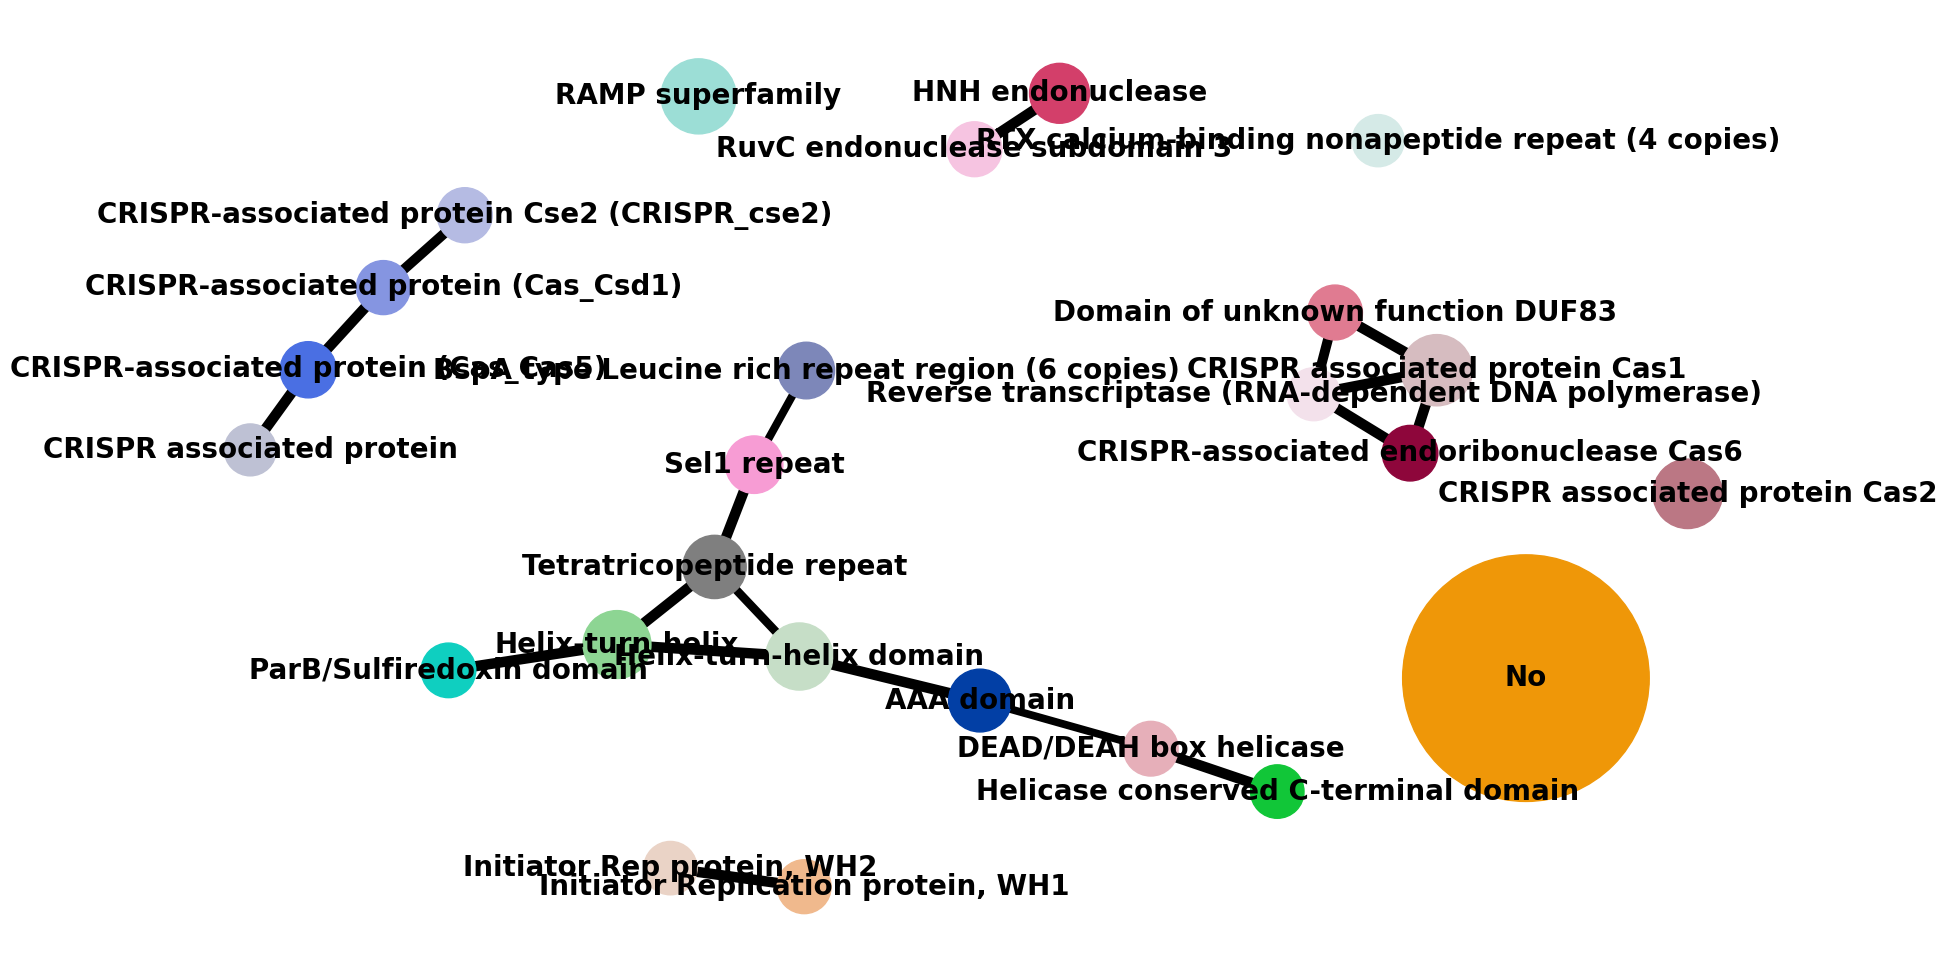

In [34]:
import matplotlib.pyplot as plt

# 增加默认字体大小
plt.rcParams.update({'font.size': 14})  # 你可以根据需要调整这个值

plt.figure(figsize=(12, 8))
sc.pl.paga(esm_all_pfam_embedding_adata, threshold=0.7, color='Signature description', show=False,
           node_size_scale=12,  # 增加节点大小
           edge_width_scale=1,   # 增加边的宽度
           fontsize=20,          # 设置标签字体大小
           fontweight='bold',
           frameon=False,
           random_state=42,)        # 移除边框以减少视觉干扰
plt.gcf().set_size_inches(20,12)

plt.tight_layout()
plt.show()

by louvain groups

In [113]:
esm_all_pfam_embedding_adata.obs['Signature description'] = esm_all_pfam_embedding_df['Signature description'].values
sc.tl.louvain(esm_all_pfam_embedding_adata, 1)

array(['RAMP superfamily', 'CRISPR associated protein Cas1',
       'CRISPR associated protein Cas2', 'Helix-turn-helix',
       'Helix-turn-helix domain', 'Tetratricopeptide repeat',
       'AAA domain', 'HNH endonuclease', 'Sel1 repeat',
       'BspA type Leucine rich repeat region (6 copies)',
       'CRISPR-associated protein (Cas_Cas5)',
       'CRISPR-associated endoribonuclease Cas6',
       'CRISPR-associated protein Cse2 (CRISPR_cse2)',
       'Domain of unknown function DUF83',
       'RuvC endonuclease subdomain 3', 'DEAD/DEAH box helicase',
       'ParB/Sulfiredoxin domain', 'CRISPR-associated protein (Cas_Csd1)',
       'Initiator Replication protein, WH1',
       'Helicase conserved C-terminal domain',
       'Initiator Rep protein, WH2',
       'Reverse transcriptase (RNA-dependent DNA polymerase)',
       'RTX calcium-binding nonapeptide repeat (4 copies)',
       'CRISPR associated protein'], dtype=object)

In [165]:
louvain_groups

Signature description louvain
0                                                      No      20
1                                                      No       0
2                                                      No      30
3                                                      No       5
4                                                      No       0
...                                                   ...     ...
141292                                                 No      13
141293            CRISPR-associated endoribonuclease Cas6      25
141294                                                 No      22
141295  CRISPR-associated negative auto-regulator DevR...      13
141296                                                 No      22

[141297 rows x 2 columns]

In [166]:
import pandas as pd

# 获取唯一的 Louvain 组
unique_louvain_groups = esm_all_pfam_embedding_adata.obs['louvain'].unique()

group_labels = []
for group in unique_louvain_groups:
    group_data = esm_all_pfam_embedding_adata.obs[esm_all_pfam_embedding_adata.obs['louvain'] == group]
    label_counts = group_data['Signature description'].value_counts()
    
    # 移除 'No' 标签并计算非 'No' 标签的总数
    if 'No' in label_counts.index:
        no_count = label_counts['No']
        label_counts = label_counts.drop('No')
        non_no_total = len(group_data) - no_count
    else:
        non_no_total = len(group_data)
    
    if not label_counts.empty:
        top_label = label_counts.index[0]
        top_count = label_counts.iloc[0]
        proportion = top_count / non_no_total if non_no_total > 0 else 0
    else:
        top_label = 'N/A'
        top_count = 0
        proportion = 0
    
    group_labels.append({
        'Louvain Group': group,
        'Top Label': top_label,
        'Top Label Count': top_count,
        'Proportion': proportion,
        'Total Size': len(group_data),
        'Non-No Size': non_no_total
    })

# 创建 DataFrame
group_labels_df = pd.DataFrame(group_labels)

# 计算 Louvain 组的大小
group_sizes = esm_all_pfam_embedding_adata.obs['louvain'].value_counts()

# 显示结果
print(f"Number of unique Louvain groups: {len(unique_louvain_groups)}")
print("\nFirst few rows of group_labels_df:")
print(group_labels_df.head())
print("\nTotal number of rows in group_labels_df:", len(group_labels_df))

Number of unique Louvain groups: 115

First few rows of group_labels_df:
  Louvain Group                                          Top Label  \
0            20                                   HNH endonuclease   
1             0  Listeria-Bacteroides repeat domain (List_Bact_...   
2            30                   Phage-related minor tail protein   
3             5                      Major Facilitator Superfamily   
4            23               CRISPR-associated protein (Cas_Csy3)   

   Top Label Count  Proportion  Total Size  Non-No Size  
0              344    0.245014        1689         1404  
1              142    0.022907       13513         6199  
2               27    0.101504         940          266  
3               99    0.038869        8502         2547  
4                1    0.250000        1532            4  

Total number of rows in group_labels_df: 115


In [173]:

# 将结果转换为 DataFrame 并排序

group_labels_df = pd.DataFrame(group_labels).sort_values('Total Size', ascending=False)

# 格式化 Proportion 列为百分比
group_labels_df['Proportion'] = group_labels_df['Proportion'].apply(lambda x: f"{x:.2%}")
group_labels_df = group_labels_df.sort_values(by='Top Label Count',ascending=False)

In [120]:
sc.tl.paga(esm_all_pfam_nembedding_adata,groups='louvain')

C:\Users\13330\AppData\Local\Temp\ipykernel_35424\4109805052.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

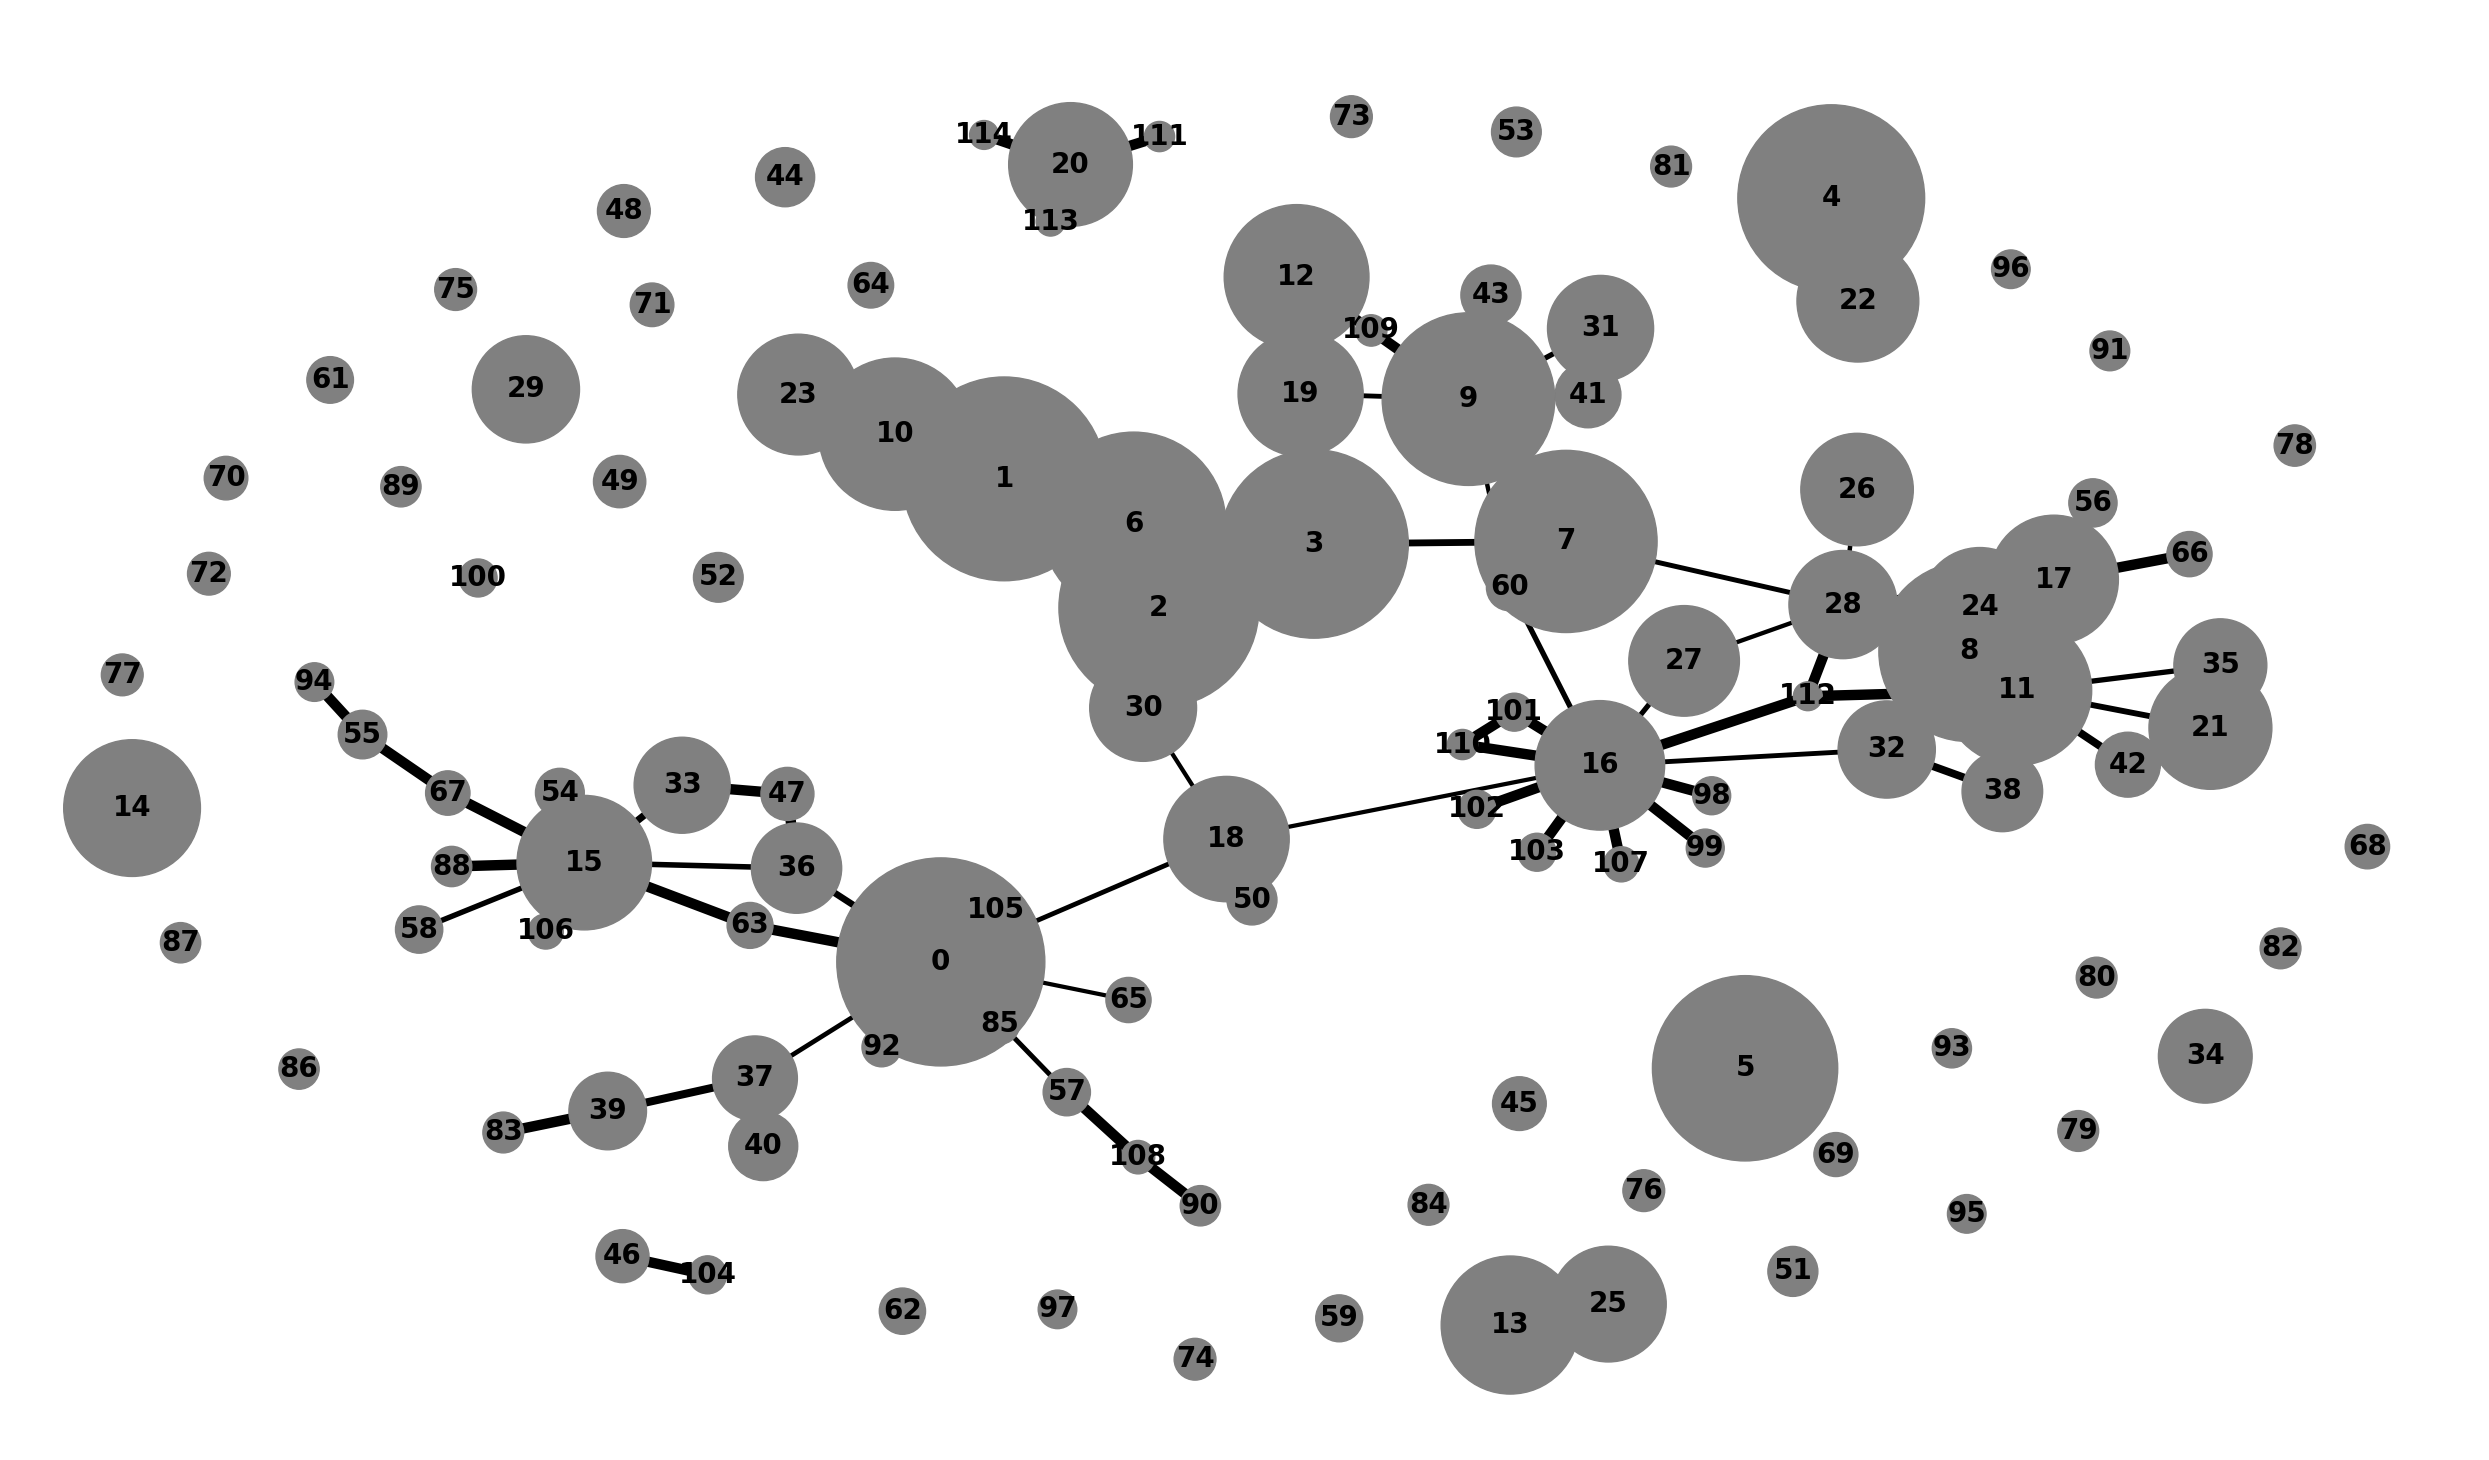

In [153]:
import matplotlib.pyplot as plt

# 增加默认字体大小
plt.rcParams.update({'font.size': 14})  # 你可以根据需要调整这个值

plt.figure(figsize=(12, 8))
sc.pl.paga(esm_all_pfam_embedding_adata, threshold=0.4, color='louvain', show=False,
           node_size_scale=12,  # 增加节点大小
           edge_width_scale=1,   # 增加边的宽度
           fontsize=20,          # 设置标签字体大小
           fontweight='bold',
           frameon=False,
           random_state=42,)        # 移除边框以减少视觉干扰
plt.gcf().set_size_inches(30,18)

plt.tight_layout()
plt.show()

### How to assign each group?
- Assign top n pfam labels

In [190]:
esm_filtered_pfam_labels = esm_all_pfam_embedding_df_filtered.value_counts()
esm_filtered_pfam_labels = esm_filtered_pfam_labels[esm_filtered_pfam_labels.index != 'No']
esm_filtered_pfam_labels = pd.DataFrame(esm_filtered_pfam_labels).reset_index().loc[:,'Signature description'].values


In [205]:

# 创建新的标签列
group_labels_df['New Label'] = group_labels_df['Louvain Group'].astype(str) + '/' + group_labels_df['Top Label']

# 创建从 Louvain Group 到新标签的映射，只保留在 esm_filtered_pfam_labels 中的 top labels
def create_new_label(row):
    if row['Top Label'] in esm_filtered_pfam_labels:
        return f"{row['Louvain Group']}/{row['Top Label']}"
    else:
        return str(row['Louvain Group'])
group_labels_df['New Label'] = group_labels_df.apply(create_new_label, axis=1)
group_to_new_label = dict(zip(group_labels_df['Louvain Group'], group_labels_df['New Label']))
# 在 AnnData 对象中创建新的列
esm_all_pfam_embedding_adata.obs['louvain_new_group'] = esm_all_pfam_embedding_adata.obs['louvain'].map(group_to_new_label)
esm_all_pfam_embedding_adata.obs['louvain_new_group']
# 将新列转换为分类数据类型
esm_all_pfam_embedding_adata.obs['louvain_new_group'] = esm_all_pfam_embedding_adata.obs['louvain_new_group'].astype('category')


In [211]:
#run paga
sc.tl.paga(esm_all_pfam_embedding_adata,groups='louvain_new_group')

In [245]:
tem_obs = esm_all_pfam_embedding_adata.obs
tem_obs['color_index'] = tem_obs.apply(lambda x: 1 if x['louvain'] != x['louvain_new_group'] else 0,axis=1)

In [294]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 获取需要新颜色的组
changed_groups = tem_obs[tem_obs['color_index']==1].louvain.unique()
color_nums = len(changed_groups)

# 使用多个颜色映射
color_maps = [plt.cm.tab20, plt.cm.tab20b, plt.cm.tab20c, plt.cm.Set1, plt.cm.Set2, plt.cm.Set3]

new_colors = []
for i in range(color_nums):
    cmap = color_maps[i % len(color_maps)]
    color = cmap(i / len(color_maps))
    hex_color = mcolors.rgb2hex(color)
    
    # 确保颜色是唯一的
    while hex_color in new_colors:
        r, g, b = np.random.rand(3)
        hex_color = mcolors.rgb2hex((r, g, b))
    
    new_colors.append(hex_color)



# 创建颜色映射字典
color_map = {group: color for group, color in zip(changed_groups, new_colors)}
# 获取所有唯一的 louvain 组
all_groups = esm_all_pfam_embedding_adata.obs['louvain'].unique()

# 创建最终的颜色列表
final_colors = []
for group in all_groups:
    if group in color_map:
        final_colors.append(color_map[group])
    else:
        final_colors.append('#808080')
    break
group



'20'

In [296]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 获取需要新颜色的组
changed_groups = tem_obs[tem_obs['color_index']==1].louvain.unique()
color_nums = len(changed_groups)

# 使用多个颜色映射
color_maps = [plt.cm.tab20, plt.cm.tab20b, plt.cm.tab20c, plt.cm.Set1, plt.cm.Set2, plt.cm.Set3]

new_colors = []
for i in range(color_nums):
    cmap = color_maps[i % len(color_maps)]
    color = cmap(i / len(color_maps))
    hex_color = mcolors.rgb2hex(color)
    
    # 确保颜色是唯一的
    while hex_color in new_colors:
        r, g, b = np.random.rand(3)
        hex_color = mcolors.rgb2hex((r, g, b))
    
    new_colors.append(hex_color)

# 创建颜色映射字典
color_map = {group: color for group, color in zip(changed_groups, new_colors)}

# 获取所有唯一的 louvain 组
all_groups = esm_all_pfam_embedding_adata.obs['louvain'].unique()

# 创建最终的颜色列表，先全部填充为 '#808080'
final_colors = ['#808080'] * len(all_groups)

# 然后为变化的组分配新颜色
for i, group in enumerate(all_groups):
    if group in color_map:
        final_colors[i] = color_map[group]

# 将新的颜色列表保存到 AnnData 对象中
esm_all_pfam_embedding_adata.uns['louvain_new_group_colors'] = final_colors


# 返回最终的颜色列表
final_colors

['#1f77b4',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#9c9ede',
 '#fdae6b',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#ff7f00',
 '#ffd92f',
 '#ccebc5',
 '#808080',
 '#808080',
 '#808080',
 '#9edae5',
 '#808080',
 '#808080',
 '#de9ed6',
 '#808080',
 '#d9d9d9',
 '#999999',
 '#b3b3b3',
 '#808080',
 '#808080',
 '#ffed6f',
 '#0ecfbd',
 '#932138',
 '#72dfd0',
 '#808080',
 '#38da82',
 '#808080',
 '#7f636f',
 '#45e6e2',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#c80819',
 '#808080',
 '#808080',
 '#071501',
 '#808080',
 '#808080',
 '#21b2bb',
 '#808080',
 '#808080',
 '#fdcf64',
 '#25356f',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#8

Color mapping for all groups:
Group 20: #808080
Group 0: #808080
Group 30: #ff7f00
Group 5: #808080
Group 23: #808080
Group 1: #808080
Group 12: #808080
Group 11: #808080
Group 18: #9edae5
Group 28: #ffd92f
Group 19: #808080
Group 10: #fdae6b
Group 2: #9c9ede
Group 9: #539b1a
Group 25: #808080
Group 6: #d9d9d9
Group 7: #e19340
Group 3: #808080
Group 8: #808080
Group 4: #808080
Group 32: #1f77b4
Group 31: #b5623f
Group 94: #999999
Group 15: #808080
Group 22: #b3b3b3
Group 24: #ccebc5
Group 33: #b07b3f
Group 14: #1531e8
Group 29: #808080
Group 13: #ffed6f
Group 27: #808080
Group 16: #de9ed6
Group 17: #808080
Group 26: #808080
Group 37: #808080
Group 21: #a96ad3
Group 35: #808080
Group 34: #808080
Group 43: #808080
Group 42: #808080
Group 77: #808080
Group 49: #808080
Group 36: #808080
Group 38: #808080
Group 40: #a034be
Group 108: #808080
Group 95: #808080
Group 69: #808080
Group 41: #808080
Group 57: #808080
Group 47: #808080
Group 112: #23f47d
Group 39: #808080
Group 79: #808080
Group 

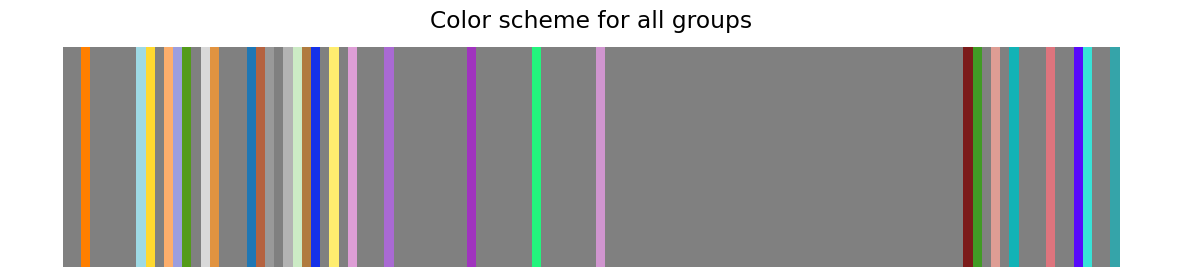

['#808080',
 '#808080',
 '#ff7f00',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#9edae5',
 '#ffd92f',
 '#808080',
 '#fdae6b',
 '#9c9ede',
 '#539b1a',
 '#808080',
 '#d9d9d9',
 '#e19340',
 '#808080',
 '#808080',
 '#808080',
 '#1f77b4',
 '#b5623f',
 '#999999',
 '#808080',
 '#b3b3b3',
 '#ccebc5',
 '#b07b3f',
 '#1531e8',
 '#808080',
 '#ffed6f',
 '#808080',
 '#de9ed6',
 '#808080',
 '#808080',
 '#808080',
 '#a96ad3',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#a034be',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#23f47d',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#d095cf',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#8

In [297]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 获取需要新颜色的组
changed_groups = tem_obs[tem_obs['color_index']==1].louvain.unique()
color_nums = len(changed_groups)

# 使用多个颜色映射
color_maps = [plt.cm.tab20, plt.cm.tab20b, plt.cm.tab20c, plt.cm.Set1, plt.cm.Set2, plt.cm.Set3]

new_colors = []
for i in range(color_nums):
    cmap = color_maps[i % len(color_maps)]
    color = cmap(i / len(color_maps))
    hex_color = mcolors.rgb2hex(color)
    
    # 确保颜色是唯一的
    while hex_color in new_colors:
        r, g, b = np.random.rand(3)
        hex_color = mcolors.rgb2hex((r, g, b))
    
    new_colors.append(hex_color)

# 创建颜色映射字典
color_map = {group: color for group, color in zip(changed_groups, new_colors)}

# 获取所有唯一的 louvain 组
all_groups = esm_all_pfam_embedding_adata.obs['louvain'].unique()

# 创建最终的颜色列表，先全部填充为 '#808080'
final_colors = ['#808080'] * len(all_groups)

# 然后为变化的组分配新颜色
for group in all_groups:
    if group in color_map:
        final_colors[int(group)] = color_map[group]

# 将新的颜色列表保存到 AnnData 对象中
esm_all_pfam_embedding_adata.uns['louvain_new_group_colors'] = final_colors

# 打印颜色映射，以便检查
print("Color mapping for all groups:")
for i, (group, color) in enumerate(zip(all_groups, final_colors)):
    print(f"Group {group}: {color}")

print(f"\nTotal number of colors: {len(final_colors)}")
print(f"Number of unique colors: {len(set(final_colors))}")

# 可视化这些颜色
plt.figure(figsize=(15, 3))
for i, color in enumerate(final_colors):
    plt.bar(i, 1, color=color, width=1)
plt.title("Color scheme for all groups")
plt.axis('off')
plt.show()

# 返回最终的颜色列表
final_colors

In [ ]:





# 将新的颜色列表保存到 AnnData 对象中
esm_all_pfam_embedding_adata.uns['louvain_new_group_colors'] = final_colors

In [273]:
esm_all_pfam_embedding_adata.uns['louvain_new_group_colors'].

115

C:\Users\13330\AppData\Local\Temp\ipykernel_35424\1708733476.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

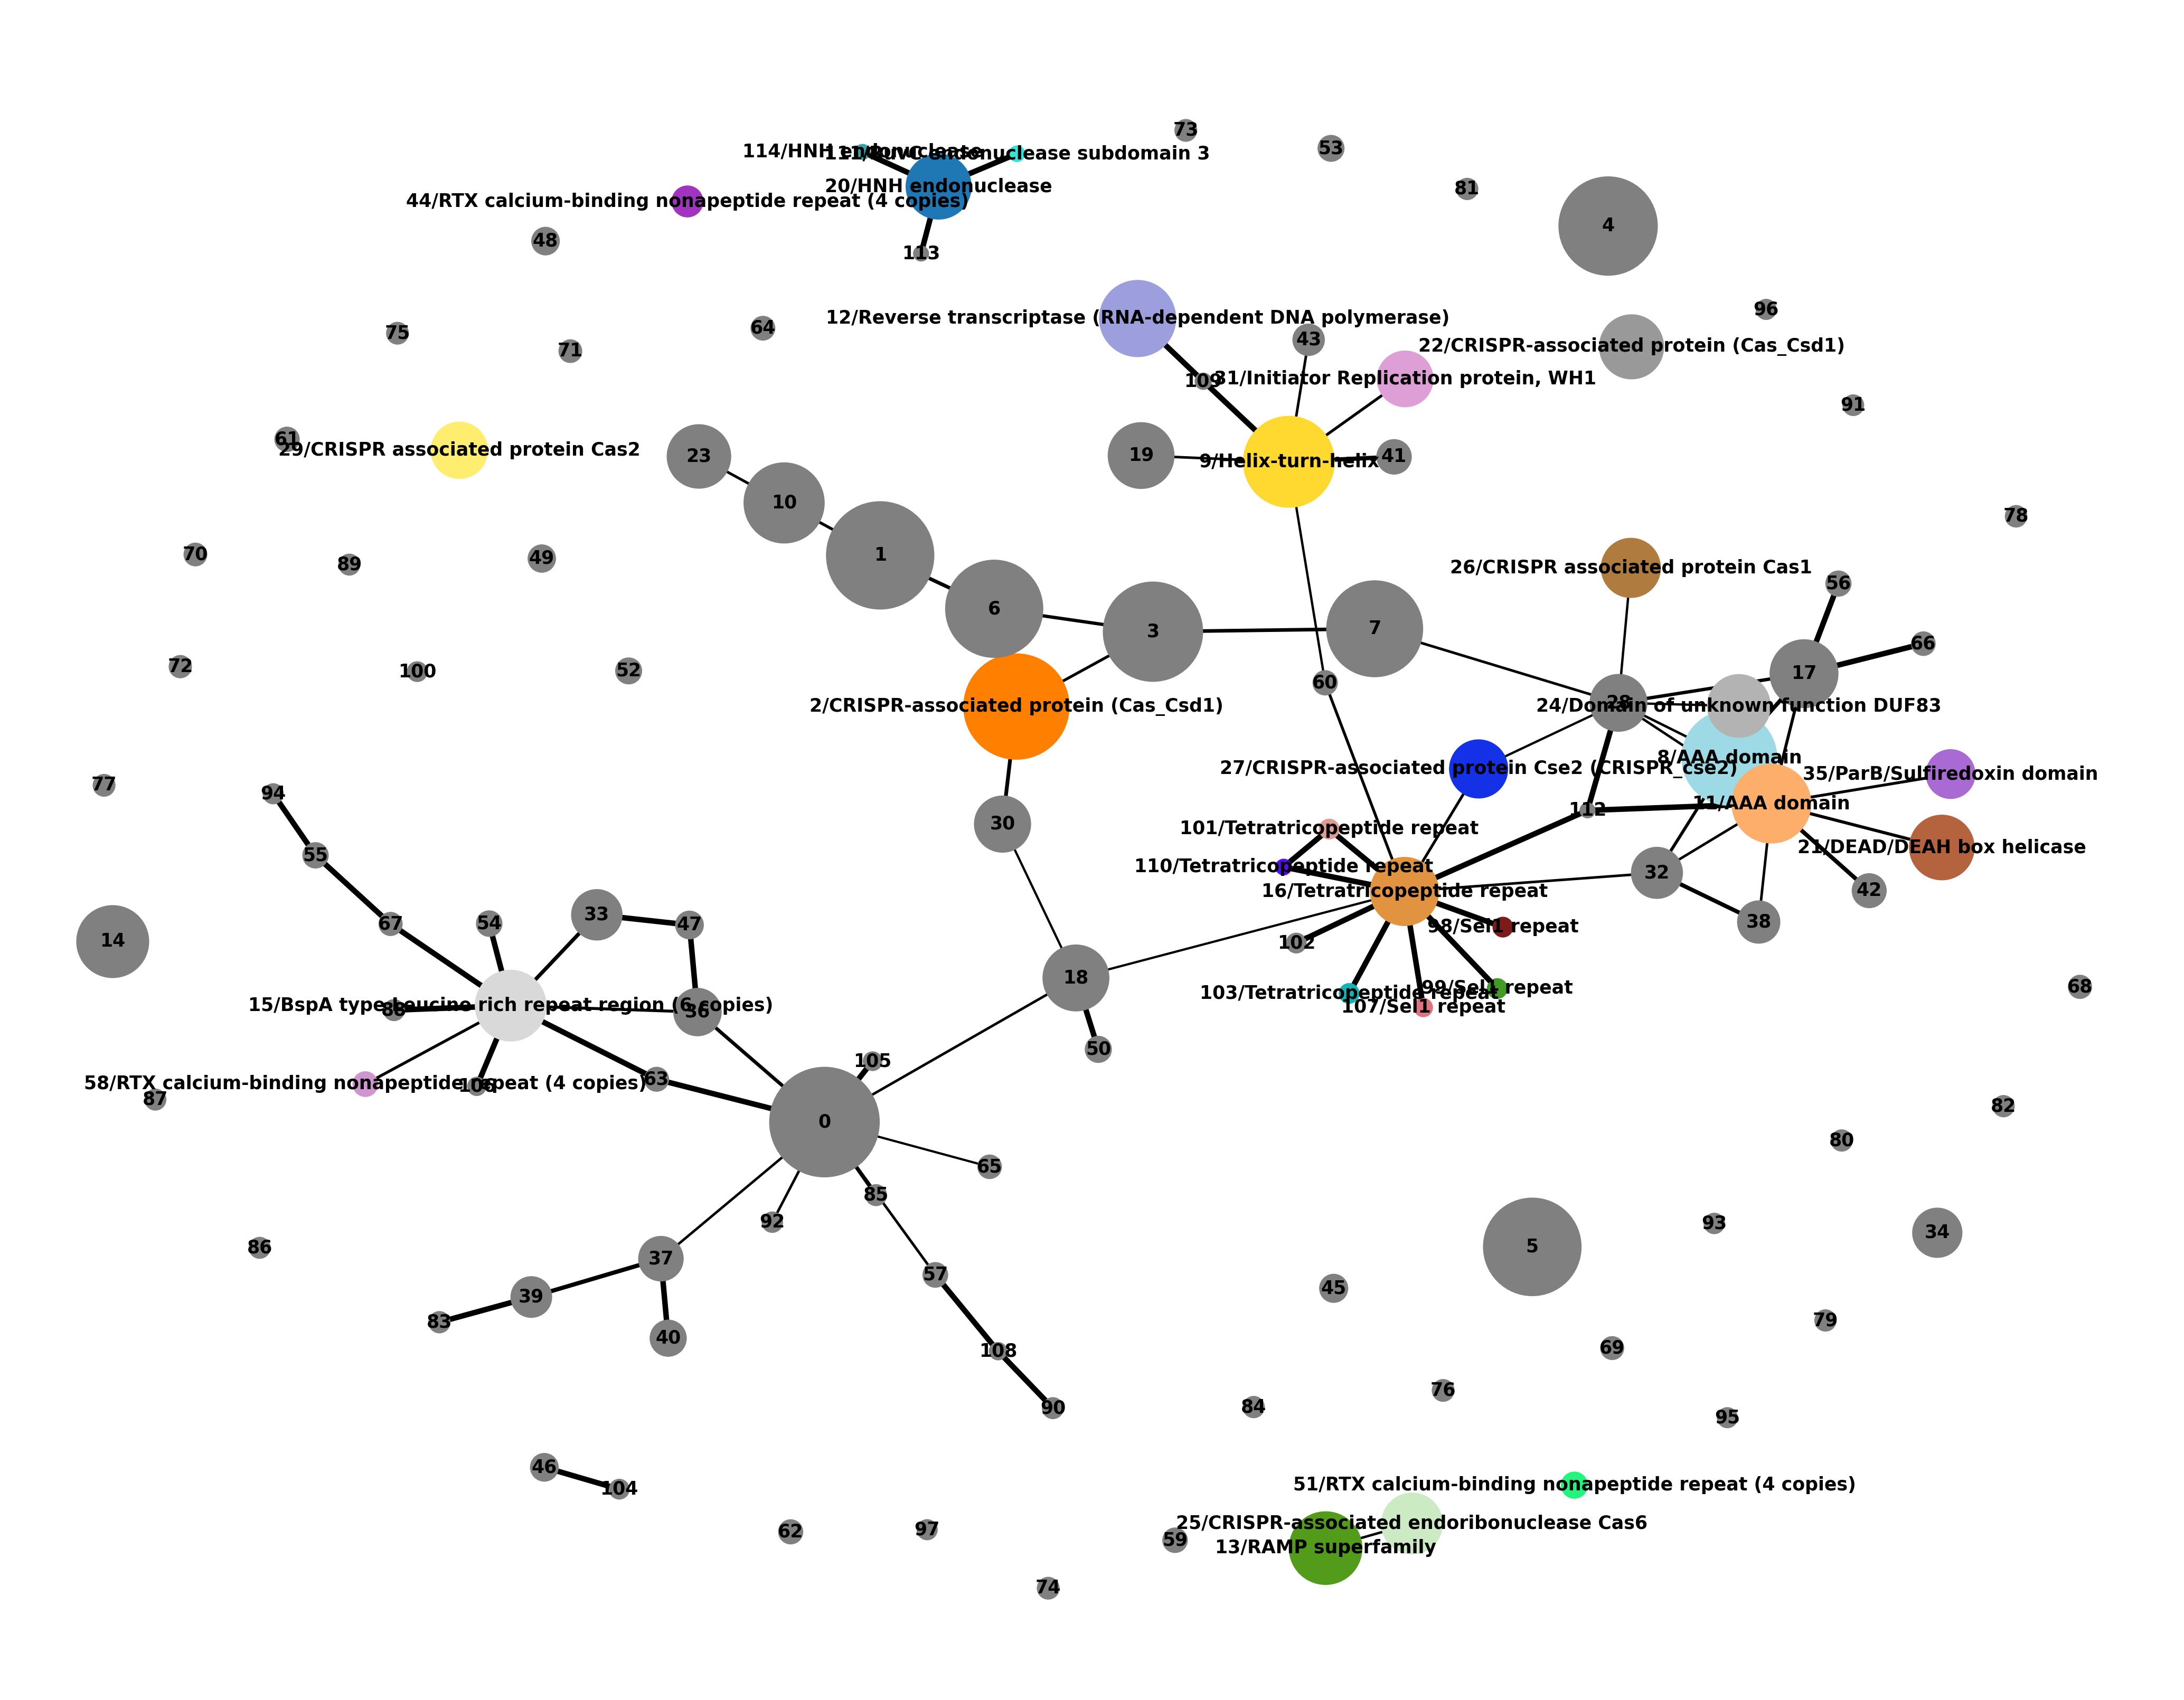

In [307]:
import matplotlib.pyplot as plt

# 增加默认字体大小
plt.rcParams.update({'font.size': 14})  # 你可以根据需要调整这个值

plt.figure(figsize=(12, 8))
sc.pl.paga(esm_all_pfam_embedding_adata, threshold=0.4, color='louvain_new_group', show=False,
           node_size_scale=12,  # 增加节点大小
           edge_width_scale=1,   # 增加边的宽度
           fontsize=25,          # 设置标签字体大小
           fontweight='bold',
           frameon=False,
           random_state=42,)        # 移除边框以减少视觉干扰
plt.gcf().set_size_inches(50,40)

plt.tight_layout()
plt.show()

## Subtask 3.3 KNN label propagation

In [123]:
k = 14 # k needs to be added 1
KNN_serach = KNNPropgation(k)
KNN_serach.fit(umap_embedding_euc_array)

KNNPropgation(n_neighbors=14)

In [124]:
#First find target seqs (occurrence larger than threshold)
threshold = 20
pfam_no_duplicated_counts = umap_embedding_euc_all_pfam_no_duplicated_df.loc[:,'Signature description'].value_counts()
pfam_no_duplicated = pfam_no_duplicated_counts[pfam_no_duplicated_counts >= threshold].index
umap_embedding_euc_filter_pfam_df = umap_embedding_euc_all_pfam_no_duplicated_df[umap_embedding_euc_all_pfam_no_duplicated_df.loc[:,'Signature description'].isin(pfam_no_duplicated)].reset_index(drop=True)
umap_embedding_euc_no_label_pfam_df = umap_embedding_euc_all_pfam_no_duplicated_df[umap_embedding_euc_all_pfam_no_duplicated_df.loc[:,'Signature description'] == np.nan]

In [128]:
KNN_nearest_ids

(23887, 14)

In [132]:
#get labeld ids
umap_embedding_label_id = umap_embedding_euc_filter_pfam_df.protein_id.unique()
umap_embedding_label_array = umap_embedding_euc_array[umap_embedding_label_id,]
#all nearest (include self data) ids
KNN_nearest_ids = KNN_serach.nearest_indices(umap_embedding_label_array)
umap_label_self_id, umap_label_nearest_id = KNN_nearest_ids[:,0], KNN_nearest_ids[:,1:]




(23887,)

- Frist for every point (embedding), find their labels, iter the labels
- For each label of each point, record the label in iteration, record like: {'pro_id':{'unknown_id':[],'label_n':{'support':x,'mean_distance':[],'median_distance':[]}}}
- Then for each unknown id, calculate by methods(support nums, mean distance...) to decide assignment

In [205]:
label_pfam_dict = {}
knn_self_id,knn_nearest_id = umap_label_self_id[0], umap_label_nearest_id[0,:]
def add_labels(knn_self_id,umap_label_df):
    df = umap_label_df.copy()
    extracted_labels = df[df['protein_id']==knn_self_id].loc[:,'Signature description'].values
    label_pfam_dict[knn_self_id] = {f"label_{x}":{
                                    'pfam_label': label,
                                    f'support_{x}':None,
                                    "mean_distance":None,
                                    "median_distance":None,
                                                  } for x,label in enumerate(extracted_labels) }
    return label_pfam_dict

def find_support_labels(knn_self_id,knn_nearest_id,umap_label_df):
    df = umap_label_df.copy()
    pfam_label = label_pfam_dict[knn_self_id]
    nearest_pfam_label = df[df['protein_id'].isin(knn_nearest_id)]['Signature description'].values
    print(nearest_pfam_label)

tem_self_id = umap_label_self_id[0]

add_labels(tem_self_id,umap_embedding_euc_filter_pfam_df)
find_support_labels(knn_self_id,knn_nearest_id,umap_embedding_euc_filter_pfam_df)
label_pfam_dict




['Transposase DDE domain' 'hAT family C-terminal dimerisation region'
 'Transposase DDE domain' 'Transposase DDE domain']


{7: {'label_0': {'pfam_label': 'hAT family C-terminal dimerisation region',
   'support_0': None,
   'mean_distance': None,
   'median_distance': None}}}

In [186]:
def create_nested_dict(pro_id, unknown_ids, labels_info):
    return {
        pro_id: {
            'unknown_id': unknown_ids,
            'labels': labels_info
        }
    }

# 创建一个示例
example_dict = create_nested_dict(
    pro_id='protein_1',
    unknown_ids=['unknown_1', 'unknown_2', 'unknown_3'],
    labels_info={
        'label_A': {
            'support': 10,
            'mean_distance': [0.5, 0.6, 0.7],
            'median_distance': [0.4, 0.5, 0.6]
        },
        'label_B': {
            'support': 8,
            'mean_distance': [0.3, 0.4, 0.5],
            'median_distance': [0.2, 0.3, 0.4]
        }
        # 可以继续添加更多标签
    }
)

# 打印结果
import pprint
pprint.pprint(example_dict)

# 访问数据的例子
print("\n访问数据的例子:")
print(f"Pro ID: {list(example_dict.keys())[0]}")
print(f"Unknown IDs: {example_dict['protein_1']['unknown_id']}")
print(f"Labels: {list(example_dict['protein_1']['labels'].keys())}")
for label, info in example_dict['protein_1']['labels'].items():
    print(f"\nLabel: {label}")
    print(f"  Support: {info['support']}")
    print(f"  Mean distances: {info['mean_distance']}")
    print(f"  Median distances: {info['median_distance']}")

{'protein_1': {'labels': {'label_A': {'mean_distance': [0.5, 0.6, 0.7],
                                      'median_distance': [0.4, 0.5, 0.6],
                                      'support': 10},
                          'label_B': {'mean_distance': [0.3, 0.4, 0.5],
                                      'median_distance': [0.2, 0.3, 0.4],
                                      'support': 8}},
               'unknown_id': ['unknown_1', 'unknown_2', 'unknown_3']}}

访问数据的例子:
Pro ID: protein_1
Unknown IDs: ['unknown_1', 'unknown_2', 'unknown_3']
Labels: ['label_A', 'label_B']

Label: label_A
  Support: 10
  Mean distances: [0.5, 0.6, 0.7]
  Median distances: [0.4, 0.5, 0.6]

Label: label_B
  Support: 8
  Mean distances: [0.3, 0.4, 0.5]
  Median distances: [0.2, 0.3, 0.4]
